## Table of Contents

    1. Introduction
    2. Data Loading and Exploratory Data Analysis
    3. Data Preprocessing, Feature Engineering and Feature Selection
        3.1 Dealing with missing values 
            3.1.1 Preparing Data for KNN Imputation
            3.1.2 Application of KNN Imputer
        3.2 Feature Engineering for Non-text Features
        3.3 Feature Selection for Non-text Features
        3.4 Preprocessing of Text Data
    4. Model Selection
        4.1 Benchmark Models
            4.1.1 Linear Regression
            4.1.2 Random Forest
            4.1.3 LightGBM
            4.1.4 Basic GRU
        4.2 Neural Network Models
            4.2.1 GRU
            4.2.2 LSTM
            4.2.3 TextCNN
        4.3 Comprehensive Model Architecture
    5. Application to Test Set
    6. Conclusion

## 1. Introduction
The objective of this assignment is to predict property prices for Airbnb listings in London by leveraging diverse features present in the dataset, especially the text data.

The approach involves initial exploration of all features, implementing essential data cleaning procedures, and selecting features that exhibit strong predictive potential. Subsequently, a range of models are experimented with and compared with regard to performance. Lastly, a comprehensive model is established and applied to the test set to make final predictions.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
import seaborn as sns
from scipy.stats import chi2
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.regularizers import l2
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, Dense, GRU, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, concatenate
from tensorflow.keras import losses
from keras.callbacks import EarlyStopping

* * * 
## 2. Data Loading and Exploratory Data Analysis
Both our training and test sets encompass identical features in the exact sequence. The only difference is that the training set also incorporates the target variable `price`.  

Additionally, the substantial number of features is a notable observation. We will discuss later the relevance of these features, exploring the potential for feature engineering where applicable.

In [4]:
train = pd.read_csv("ADAMS/train.csv", sep=",", encoding="utf-8")
test = pd.read_csv("ADAMS/test.csv", sep=",", encoding="utf-8")

# We won't use picture_url for price prediction
train = train.drop(columns="picture_url")
test = test.drop(columns="picture_url")

In [3]:
# Check if features are different in both sets

train_fea = set(train.columns)
test_fea = set(test.columns)

diff_fea = train_fea.symmetric_difference(test_fea)

print("Different features between train and test sets:")
for fea in diff_fea:
    print(fea)

Different features between train and test sets:
price


In [4]:
# Number of features in both sets

print("Number of features in training set:", len(train.columns))
print("Number of features in test set:", len(test.columns))

Number of features in training set: 41
Number of features in test set: 40


***
We compute the percentage of missing values for each feature and visualize the distribution of these missing values.

Of particular note are the significant instances of missing values in two groups:
1. Host response related features: `host_response_time`, `host_response_rate`, 
2. Review score related features: `review_scores_rating`, `review_scores_accuracy`, `review_scores_cleanliness`, `review_scores_checkin`, `review_scores_communication`, `review_scores_location`, `review_scores_value`, `reviews_per_month`  

In [5]:
train.isnull().sum()

name                              14
summary                         2954
space                          16881
description                     1726
experiences_offered                0
neighborhood_overview          19506
transit                        19807
house_rules                    23378
host_id                            0
host_since                       111
host_response_time             17802
host_response_rate             17802
host_is_superhost                111
host_total_listings_count        111
host_has_profile_pic             111
host_identity_verified           111
neighbourhood                    147
neighbourhood_cleansed             0
zipcode                         1272
latitude                           0
longitude                          0
property_type                      0
room_type                          0
accommodates                       0
bathrooms                         70
bedrooms                          62
beds                             262
b

In [8]:
test.isnull().sum()

name                              10
summary                         1577
space                           9057
description                      943
experiences_offered                0
neighborhood_overview          10551
transit                        10672
house_rules                    12580
host_id                            0
host_since                        65
host_response_time              9572
host_response_rate              9572
host_is_superhost                 65
host_total_listings_count         65
host_has_profile_pic              65
host_identity_verified            65
neighbourhood                     86
neighbourhood_cleansed             0
zipcode                          635
latitude                           0
longitude                          0
property_type                      0
room_type                          0
accommodates                       0
bathrooms                         50
bedrooms                          29
beds                             142
b

In [6]:
# Percentage of missing values in each feature
# training set
mis_perc_train = train.isnull().mean() * 100
mis_perc_train.sort_values(ascending=False)

house_rules                    42.287099
transit                        35.827726
neighborhood_overview          35.283265
host_response_time             32.200998
host_response_rate             32.200998
space                          30.535055
review_scores_checkin          24.388612
review_scores_value            24.383185
review_scores_location         24.383185
review_scores_accuracy         24.325302
review_scores_communication    24.321684
review_scores_cleanliness      24.314449
review_scores_rating           24.265610
reviews_per_month              22.393459
summary                         5.343318
description                     3.122061
zipcode                         2.300847
beds                            0.473917
neighbourhood                   0.265900
host_has_profile_pic            0.200781
host_identity_verified          0.200781
host_total_listings_count       0.200781
host_is_superhost               0.200781
host_since                      0.200781
bathrooms       

In [10]:
# test set
mis_perc_test = test.isnull().mean() * 100
mis_perc_test.sort_values(ascending=False)

house_rules                    42.258726
transit                        35.849374
neighborhood_overview          35.442910
host_response_time             32.154254
host_response_rate             32.154254
space                          30.424267
review_scores_value            24.297088
review_scores_location         24.290369
review_scores_checkin          24.287010
review_scores_accuracy         24.250059
review_scores_cleanliness      24.229904
review_scores_communication    24.229904
review_scores_rating           24.186234
reviews_per_month              22.264772
summary                         5.297457
description                     3.167725
zipcode                         2.133091
beds                            0.477006
neighbourhood                   0.288891
host_has_profile_pic            0.218348
host_identity_verified          0.218348
host_total_listings_count       0.218348
host_is_superhost               0.218348
host_since                      0.218348
bathrooms       

<Axes: >

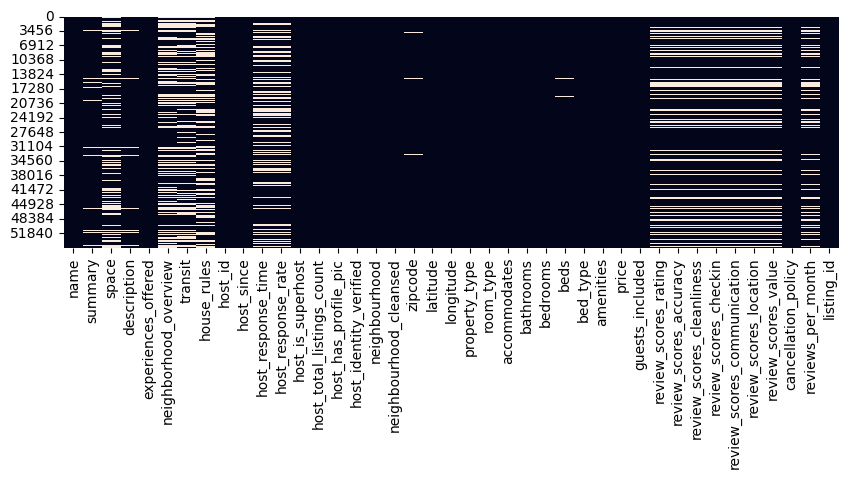

In [7]:
# Visualizing the distribution of missing values in the training set

plt.figure(figsize=(10, 3))
sns.heatmap(train.isnull(), cbar=False)

<Axes: >

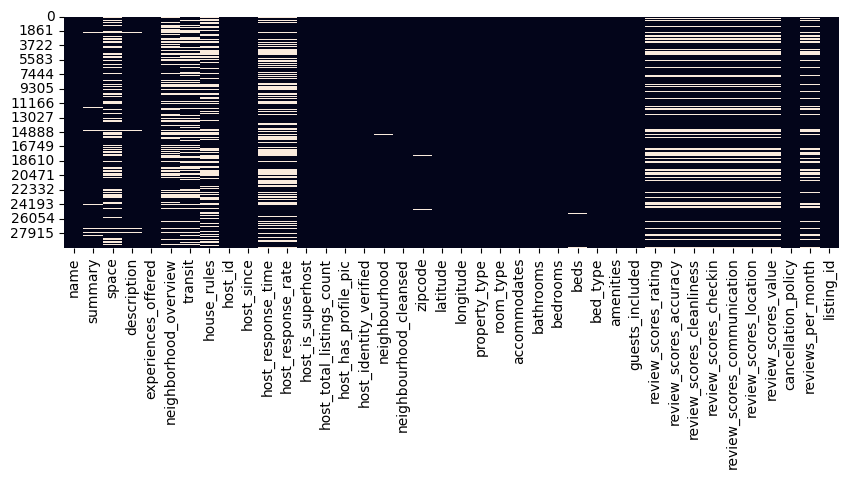

In [8]:
# Visualizing the distribution of missing values in the test set

plt.figure(figsize=(10, 3))
sns.heatmap(test.isnull(), cbar=False)

In both the training and test set, we notice a concurrent pattern of the missing values in the two host response related features and in the eight review scores related features. Furthermore, the large proportion of missing values within these areas is hard to ignore.  

Our discussion on addressing these missing values will follow.
***

Subsequently, we turn our attention to a feature that holds significant importance intuitively: the listing's location. To gain a comprehensive borough-level perspective, we opt for `neighbourhood_cleansed`, which incorporates the 32 London Boroughs plus the City of London.

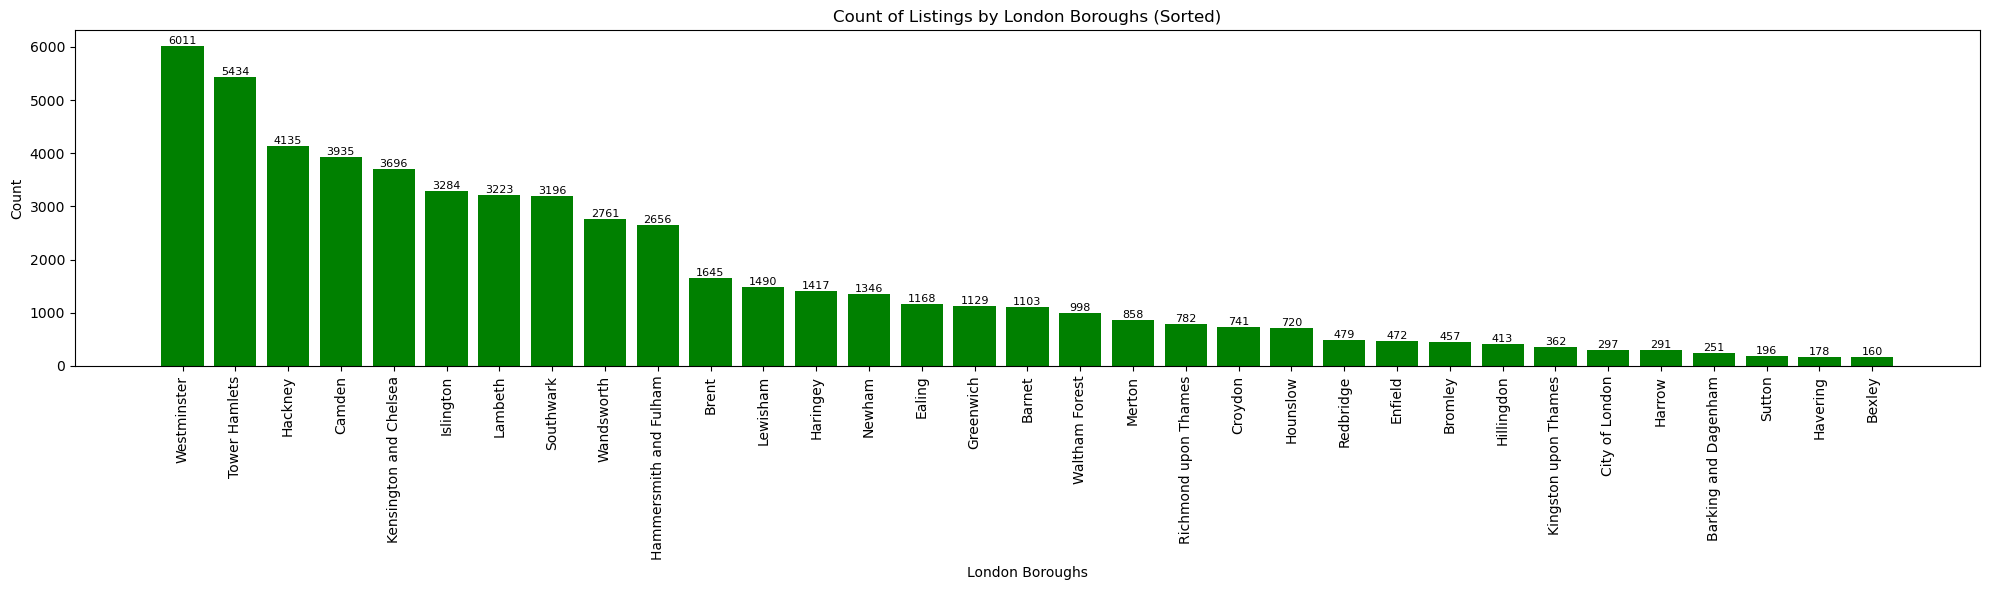

In [13]:
cnts = train['neighbourhood_cleansed'].value_counts()

plt.figure(figsize=(20, 6))
plt.bar(cnts.index, cnts.values, color='green')
plt.xlabel('London Boroughs')
plt.ylabel('Count')
plt.title('Count of Listings by London Boroughs (Sorted)')
plt.xticks(rotation=90)

for i, count in enumerate(cnts.values):
    plt.annotate(count, (i, count), ha='center', va='bottom', fontsize=8)

plt.tight_layout()

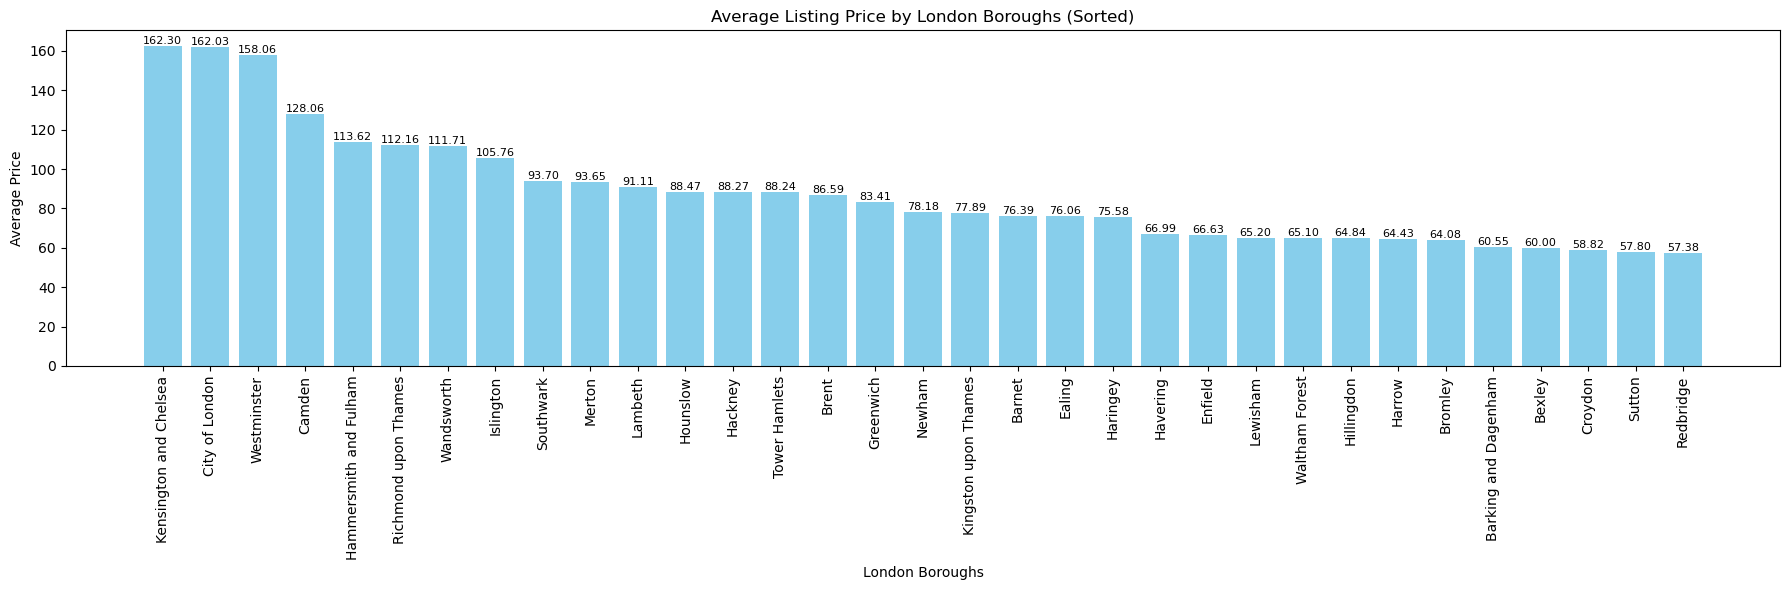

In [14]:
avg_price = train.groupby('neighbourhood_cleansed')['price'].mean().reset_index()
avg_price_sorted = avg_price.sort_values(by='price', ascending=False)

plt.figure(figsize=(18, 6))
plt.bar(avg_price_sorted['neighbourhood_cleansed'], avg_price_sorted['price'], color='skyblue')
plt.xlabel('London Boroughs')
plt.ylabel('Average Price')
plt.title('Average Listing Price by London Boroughs (Sorted)')
plt.xticks(rotation=90)

for i, price in enumerate(avg_price_sorted['price']):
    plt.annotate(f"{price:.2f}", (i, price), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

To enrich our understanding, we enhance our analysis with the inclusion of map data from London Datastore (https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london), which aids in creating a more insightful visualization.   
It's important to clarify that this map data serves solely for visualization purposes and doesn't influence subsequent steps.

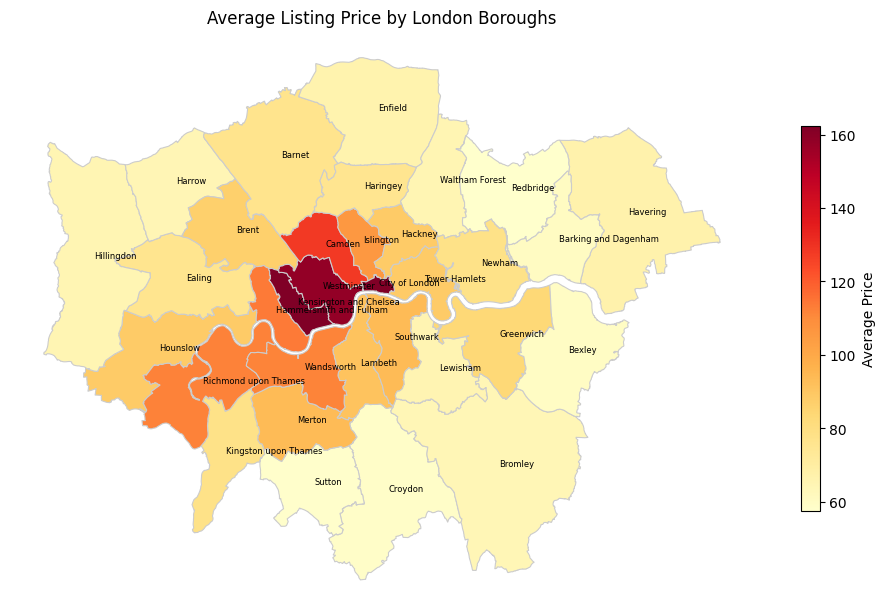

In [10]:
import geopandas as gpd

avg_price = train.groupby('neighbourhood_cleansed')['price'].mean().reset_index()

fp = 'statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp'
map_df = gpd.read_file(fp)

# Merge the map data with our price data grouped by neighbourhood_cleansed
merged = map_df.merge(avg_price, left_on='NAME', right_on='neighbourhood_cleansed')

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
merged.plot(column='price', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, legend_kwds={'label': "Average Price", 'orientation': "vertical", 'shrink': 0.5})

for idx, row in merged.iterrows():
    plt.annotate(text=row['neighbourhood_cleansed'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y), fontsize=6, color='black')

ax.set_title('Average Listing Price by London Boroughs')
ax.axis('off')
plt.show()

It is obvious that there are distinct variations in both the distribution of listings and the average prices across different boroughs. This observation emphasizes the significance of `neighbourhood_cleansed` as a potentially influential indicator of prices.  
***

Then, looking at the distribution of the target variable, we observe a substantial presence of outliers. Our next step involves scrutinizing these outliers to ascertain their legitimacy.

<Axes: title={'center': 'Price Distribution Boxplot'}>

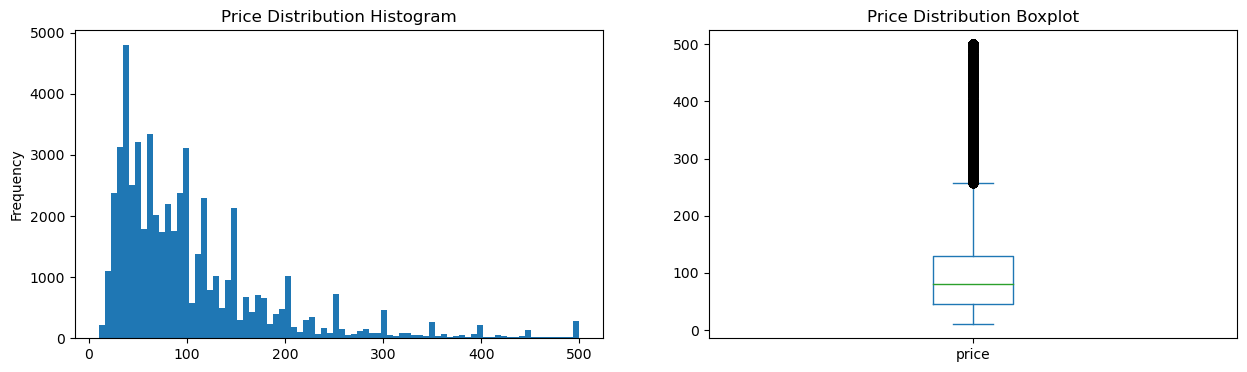

In [5]:
plt.subplots(1, 2, figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.title("Price Distribution Histogram")
train.price.plot.hist(bins=80)
plt.subplot(1, 2, 2)
plt.title("Price Distribution Boxplot")
train.price.plot.box()

In [6]:
# Calculating the lower and upper bound
Q1 = train['price'].quantile(0.25)
Q3 = train['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train[(train['price'] < lower_bound) | (train['price'] > upper_bound)]

# Inspecting locations of these outliers
outliers_neigh = outliers['neighbourhood_cleansed']

print("Number of outliers:",outliers.shape[0])
print(outliers_neigh)

Number of outliers: 3120
13                Tower Hamlets
69                      Hackney
90                Tower Hamlets
93                    Islington
115      Kensington and Chelsea
                  ...          
55123    Kensington and Chelsea
55138               Westminster
55158                 Islington
55181    Kensington and Chelsea
55254    Kensington and Chelsea
Name: neighbourhood_cleansed, Length: 3120, dtype: object


In [7]:
outliers_neigh.value_counts()

Westminster               894
Kensington and Chelsea    512
Camden                    346
Hammersmith and Fulham    183
Wandsworth                181
Tower Hamlets             153
Islington                 148
Hackney                   109
Lambeth                   101
Southwark                  79
Brent                      67
Richmond upon Thames       58
Merton                     48
Haringey                   40
City of London             30
Barnet                     26
Hounslow                   24
Newham                     23
Ealing                     21
Greenwich                  19
Lewisham                   13
Kingston upon Thames        8
Croydon                     7
Enfield                     7
Hillingdon                  6
Waltham Forest              6
Harrow                      3
Barking and Dagenham        2
Bexley                      2
Bromley                     2
Redbridge                   1
Havering                    1
Name: neighbourhood_cleansed, dtype: int

Most outliers are indeed situated within boroughs characterized by higher average prices. We therefore refrain from truncating them.
*** 

We do identify some potential duplicated listings by selectiong those with the same `name`, `host_id`, and `price`. However, upon closer examination of several cases, we find it difficult to tell if they are indeed duplicated, since the values of other features, such as accommodates, beds, etc. are often different.

As a result, we choose to retain these listings that might appear as duplicates.

In [8]:
# Find duplicate rows based on 'name', 'host_id', 'price'
train[train.duplicated(subset=['name', 'host_id', 'price'], keep=False) & train['name'].notnull() & train['host_id'].notnull()]

,name,summary,space,description,experiences_offered,neighborhood_overview,transit,house_rules,host_id,host_since,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,listing_id
293,✪AMAZING COSY FLAT✪Green✪ CENTRAL LONDON➔ ZONE 2,Enjoy one bedroom newly refurbished flat in We...,The flat offers: - Newly refurbished kitchen w...,Enjoy one bedroom newly refurbished flat in We...,none,The flat is situated 5 min from West Kensingto...,The flat is a 2 min walk from the West Kensing...,NaN,166728372,2018-01-09,...,84.0,9.0,9.0,10.0,10.0,10.0,8.0,moderate,1.90,W3JPZSVXKV
348,The Alma Rooms,Great for self catering in Cenral London,NaN,Great for self catering in Cenral London,none,NaN,NaN,NaN,57986943,2016-02-09,...,95.0,10.0,10.0,10.0,9.0,10.0,8.0,moderate,0.46,RPJ06VMQEC
388,"Luxury Studio by London Eye, Big Ben & Vauxhall","Exclusive Studio by the London Eye, Big Ben, B...",NaN,"Exclusive Studio by the London Eye, Big Ben, B...",none,NaN,NaN,NaN,27185900,2015-02-03,...,97.0,10.0,10.0,10.0,10.0,10.0,9.0,strict_14_with_grace_period,2.54,AAH3F3SK29
523,Brick Lane Shoreditch Sanctuary,My Two Bedroom Apartment is close to Brick Lan...,Our apartment is located on the 2nd and 3rd fl...,My Two Bedroom Apartment is close to Brick Lan...,none,"Shoreditch host some of the best Night Spots, ...",There are many buses that can take you anywher...,"1. We have a strict NO PARTY rule, if you have...",111291126,2017-01-13,...,91.0,9.0,9.0,9.0,10.0,10.0,9.0,strict_14_with_grace_period,1.40,2Q3IW1GL3S
556,Luxury 2 bedroom in Central London,My Luxury Two Bedroom apartment is located min...,The two bedroom apartment is ideal for six gue...,My Luxury Two Bedroom apartment is located min...,none,The magnificent St Paul’s Cathedral is one of ...,Getting around • London (LHR-Heathrow) 51-min ...,Rules: No Party Policy: There is a strict 21 ...,36126550,2015-06-18,...,100.0,10.0,10.0,10.0,10.0,10.0,6.0,strict_14_with_grace_period,0.63,L6GFCWEW7M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54275,Centrally Located Tower Hill/Aldagte East Studios,Lovely studios situated in an excellent centra...,Situated in an excellent central location. Tow...,Lovely studios situated in an excellent centra...,none,NaN,"Towerhill DLR station is a stone throw away, a...",- Kindly note that the lead guest must be 21 y...,116397015,2017-02-14,...,91.0,10.0,9.0,10.0,10.0,9.0,9.0,strict_14_with_grace_period,1.65,B847LUNK6U
54365,St Pauls Apartments,"In the City of London district of London, clos...",NaN,"In the City of London district of London, clos...",none,NaN,NaN,"No smoking, No parties, and no visitors allowed",224967268,2018-11-09,...,70.0,8.0,6.0,6.0,6.0,10.0,9.0,strict_14_with_grace_period,0.36,673J056LSD
54540,Private room for 2 in vibrant Vauxhall,Hey! :) Here is one of my rooms available in ...,"The room is located beside Tia Maria, our Braz...",Hey! :) Here is one of my rooms available in ...,none,Down-to-earth Vauxhall is known for its nightl...,"The flat is located close to Victoria Station,...",NaN,95693343,2016-09-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flexible,NaN,BWSS1L1W50
55183,Brand New & Modern Studio Flat in Hounslow,The studio is located within walking distance ...,This brand new and luxury studio consists of a...,The studio is located within walking distance ...,none,Hounslow it's really close to Heathrow Airport...,Nearest stations Hounslow Central (0.9 mi) 13 ...,- Key exchange to be done in person – under no...,121666404,2017-03-20,...,85.0,9.0,10.0,9.0,9.0,9.0,9.0,flexible,2.11,6LDUYZ6UWS


***
## 3. Data Preprocessing, Feature Engineering and Feature Selection
### 3.1 Dealing with missing values  

Let's focus on missing values in non-text features first.  

As previously noted, a pattern of missing values exists withinthe the two host response related features and the eight review scores related features, which is compounded by a large proportion.   

We employ the custom Little's MCAR test in assessing if missing values in non-text features are missing completely at random:

In [9]:
non_text = ['host_id',
       'host_since', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'zipcode', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'guests_included',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'cancellation_policy', 'reviews_per_month',
       'listing_id']

In [10]:
def littles_mcar_test(data, significance_level=0.05):
    """
    Perform Little's MCAR Test to check if missing values are missing completely at random.

    Parameters:
    - data: DataFrame, input data
    - significance_level: float, significance level for the test

    Returns:
    - is_mcar: bool, True if missing values are missing completely at random, False otherwise
    """

    # Calculate observed frequencies of missingness patterns
    observed_frequencies = data.isnull().sum()

    # Calculate expected frequencies assuming MCAR
    total_missing = observed_frequencies.sum()
    expected_frequencies = (observed_frequencies / total_missing) * data.shape[0]

    # Calculate the Chi-squared statistic
    chi_squared = np.sum((observed_frequencies - expected_frequencies) ** 2 / expected_frequencies)

    # Calculate degrees of freedom
    df = len(observed_frequencies) - 1

    # Calculate p-value using Chi-squared distribution
    p_value = 1 - chi2.cdf(chi_squared, df)

    # Calculate critical value from Chi-squared distribution
    critical_value = chi2.ppf(1 - significance_level, df)

    # Compare Chi-squared statistic with critical value
    is_mcar = chi_squared <= critical_value

    return is_mcar

In [11]:
is_mcar = littles_mcar_test(train[non_text])
print("Missing values are MCAR:", is_mcar)

Missing values are MCAR: False


In [12]:
is_mcar = littles_mcar_test(test[non_text])
print("Missing values are MCAR:", is_mcar)

Missing values are MCAR: False


In this case, filling missing values simply with the mean, median, mode, or the most frequent category is not an ideal way. Instead, we opt for applying k-Nearest Neighbor Imputation algorithm to estimate missing values, which are calculated based on non-missing values in the k nearby samples.  

#### 3.1.1 Preparing data for KNN Imputation

For KNN Imputation, we only take the subset of non-text data with missing values. 

However, it's worth noting that `host_response_time` and `host_response_rate` exhibit 32% missing values, even imputation may be problematic.  
Moreover, considering that our goal is property price prediction, these two variables are logically speaking less relevant for a property's price, as compared to review scores, which also contain notable missing values.   
Thus, we choose to exclude **`host_response_time` and `host_response_rate`** from the set of features that will be imputed, while retaining review scores related features since they are relatively more important for our price prediction task.   

In [13]:
# Numeric/categorical variables WITHOUT missing values are excluded: 'property_type', 'room_type', 'accommodates', 'bed_type', 'amenities', 'cancellation_policy', 'guests_included' 

impute_set = train[['host_since', 'host_is_superhost', 'host_total_listings_count', 'host_has_profile_pic', 
       'host_identity_verified', 'bathrooms', 'bedrooms', 'beds', 
       'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
       'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month']].copy()

impute_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55284 entries, 0 to 55283
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_since                   55173 non-null  object 
 1   host_is_superhost            55173 non-null  object 
 2   host_total_listings_count    55173 non-null  float64
 3   host_has_profile_pic         55173 non-null  object 
 4   host_identity_verified       55173 non-null  object 
 5   bathrooms                    55214 non-null  float64
 6   bedrooms                     55222 non-null  float64
 7   beds                         55022 non-null  float64
 8   review_scores_rating         41869 non-null  float64
 9   review_scores_accuracy       41836 non-null  float64
 10  review_scores_cleanliness    41842 non-null  float64
 11  review_scores_checkin        41801 non-null  float64
 12  review_scores_communication  41838 non-null  float64
 13  review_scores_lo

In [14]:
# Apply to test set
impute_set_test = test[['host_since', 'host_is_superhost', 'host_total_listings_count', 'host_has_profile_pic', 
       'host_identity_verified', 'bathrooms', 'bedrooms', 'beds', 
       'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
       'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month']].copy()

Next, we take steps to ensure that the data is in correct types and values that KNN Imputer can work with by engaging in some feature engineering.  

* * * 

**`host_since`** signifies the date a host joined Airbnb. It's therefore reasonable to calculate a numeric value for representing how long a host has been active on Airbnb based on `host_since`.   
For this computation, we adopt the latest date in `host_since` as the reference date.

In [15]:
impute_set['host_since'] = pd.to_datetime(impute_set['host_since'])

# Calculate the difference between the reference date and 'host_since'
print("Benchmark date:", impute_set['host_since'].max())
impute_set['host_since_days'] = (impute_set['host_since'].max() - impute_set['host_since']).dt.days

impute_set = impute_set.drop(columns=['host_since'])

print(impute_set['host_since_days'].isnull().sum())
impute_set['host_since_days']

Benchmark date: 2020-01-08 00:00:00
111


0        2821.0
1        2050.0
2         194.0
3        2693.0
4        1216.0
          ...  
55279    1778.0
55280     521.0
55281     921.0
55282    1385.0
55283    1696.0
Name: host_since_days, Length: 55284, dtype: float64

In [16]:
# Apply to test set
impute_set_test['host_since'] = pd.to_datetime(impute_set_test['host_since'])

print("Benchmark date:", impute_set_test['host_since'].max())
impute_set_test['host_since_days'] = (impute_set_test['host_since'].max() - impute_set_test['host_since']).dt.days

impute_set_test = impute_set_test.drop(columns=['host_since'])

Benchmark date: 2020-01-08 00:00:00


* * * 
Mapping t/f to 1/0 in **`host_is_superhost`, `host_has_profile_pic`, `host_identity_verified`**, so that we can take them as dummy variables.

In [17]:
to_map = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified']

for col in to_map:
    impute_set[col] = pd.to_numeric(impute_set[col].map({'t': 1, 'f': 0}), errors='coerce')

impute_set[to_map].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55284 entries, 0 to 55283
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_is_superhost       55173 non-null  float64
 1   host_has_profile_pic    55173 non-null  float64
 2   host_identity_verified  55173 non-null  float64
dtypes: float64(3)
memory usage: 1.3 MB


In [18]:
# Apply to test set
for col in to_map:
    impute_set_test[col] = pd.to_numeric(impute_set_test[col].map({'t': 1, 'f': 0}), errors='coerce')

In [19]:
# Make sure we've kept all NaN

impute_set.isnull().sum()

host_is_superhost                111
host_total_listings_count        111
host_has_profile_pic             111
host_identity_verified           111
bathrooms                         70
bedrooms                          62
beds                             262
review_scores_rating           13415
review_scores_accuracy         13448
review_scores_cleanliness      13442
review_scores_checkin          13483
review_scores_communication    13446
review_scores_location         13480
review_scores_value            13480
reviews_per_month              12380
host_since_days                  111
dtype: int64

* * * 
#### 3.1.2 Application of KNN Imputer

To assess the impact of KNN Imputation, we take the review scores features as our focus, computing descriptive statistics and visualizing their distribution.  

       review_scores_rating  review_scores_accuracy  \
count          41869.000000            41836.000000   
mean              92.533044                9.502868   
std               10.030620                0.982464   
min               20.000000                2.000000   
25%               90.000000                9.000000   
50%               96.000000               10.000000   
75%              100.000000               10.000000   
max              100.000000               10.000000   

       review_scores_cleanliness  review_scores_checkin  \
count               41842.000000           41801.000000   
mean                    9.261484               9.622043   
std                     1.138548               0.894931   
min                     2.000000               2.000000   
25%                     9.000000              10.000000   
50%                    10.000000              10.000000   
75%                    10.000000              10.000000   
max                    10.000000

Text(0.5, 1.0, 'Review scores boxplot')

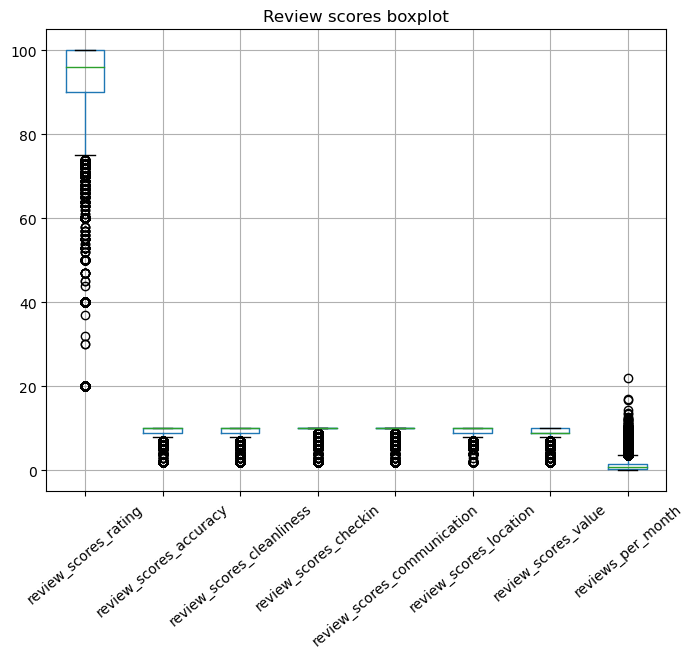

In [20]:
review_scores = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']

print(impute_set[review_scores].describe())

impute_set.boxplot(column=list(review_scores), rot=40, figsize=(8,6))
plt.title('Review scores boxplot')

Now we are ready to apply KNN Imputer:

In [21]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5) # default number of neighboring samples to use for imputation
imputed = imputer.fit_transform(impute_set)
impute_set_done = pd.DataFrame(imputed, columns=impute_set.columns)

In [22]:
# Apply to test set
imputed_test = imputer.transform(impute_set_test)
impute_set_test_done = pd.DataFrame(imputed_test, columns=impute_set_test.columns)

All missing values are imputed:

In [23]:
impute_set_done.isnull().sum().sum()

0

In [24]:
impute_set_test_done.isnull().sum().sum()

0

       review_scores_rating  review_scores_accuracy  \
count          55284.000000            55284.000000   
mean              92.804406                9.498376   
std                9.019650                0.887419   
min               20.000000                2.000000   
25%               90.000000                9.000000   
50%               95.000000               10.000000   
75%               98.800000               10.000000   
max              100.000000               10.000000   

       review_scores_cleanliness  review_scores_checkin  \
count               55284.000000           55284.000000   
mean                    9.298430               9.631101   
std                     1.024879               0.800200   
min                     2.000000               2.000000   
25%                     9.000000               9.600000   
50%                     9.600000              10.000000   
75%                    10.000000              10.000000   
max                    10.000000

Text(0.5, 1.0, 'Review scores boxplot AFTER imputation')

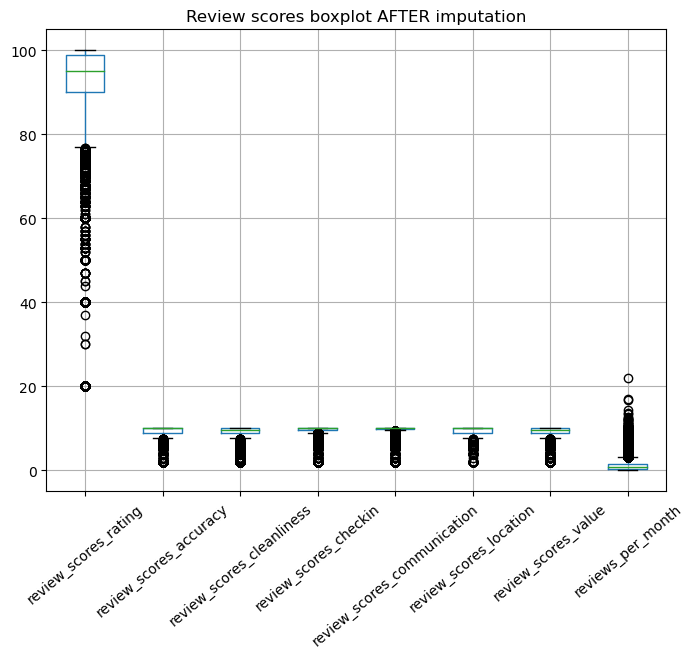

In [25]:
# Calculating descriptive statistics and visualizing distribution for data AFTER imputation

print(impute_set_done[review_scores].describe())

impute_set_done.boxplot(column=list(review_scores), rot=40, figsize=(8,6))
plt.title('Review scores boxplot AFTER imputation')

Generally speaking, the KNN Imputer has demonstrated effective performance. Descriptive statistics exhibit minimal variation, and distribution remains after imputation.  
Considering this, although the hyperparameter `n_neighbours` of KNN Imputer should be optimized by testing different values in evaluating the performance of a model, we stay with the default value 5.   

*** 

Moving forward, since KNN Imputer only outputs floating numbers, we round the values of some features whose values should be integers. 

In [26]:
should_be_int = ['host_is_superhost', 'host_total_listings_count', 'host_has_profile_pic', 'host_identity_verified', 'bedrooms', 'beds', 
        'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
        'review_scores_communication', 'review_scores_location', 'review_scores_value', 'host_since_days']

for col in should_be_int:
    impute_set_done[col] = impute_set_done[col].apply(lambda x: round(x) if not x.is_integer() else x)

In [27]:
# Check if rounding worked well

non_int_found = []

for col in should_be_int:
    is_integer_array = impute_set_done[col].apply(lambda x: x.is_integer())
    if any(~is_integer_array):
        non_int_found.append(col)

print(non_int_found)

[]


In [28]:
# Convert dtype to int
for col in should_be_int:
    impute_set_done[col] = impute_set_done[col].astype('int64')

In [29]:
impute_set_done.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55284 entries, 0 to 55283
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_is_superhost            55284 non-null  int64  
 1   host_total_listings_count    55284 non-null  int64  
 2   host_has_profile_pic         55284 non-null  int64  
 3   host_identity_verified       55284 non-null  int64  
 4   bathrooms                    55284 non-null  float64
 5   bedrooms                     55284 non-null  int64  
 6   beds                         55284 non-null  int64  
 7   review_scores_rating         55284 non-null  int64  
 8   review_scores_accuracy       55284 non-null  int64  
 9   review_scores_cleanliness    55284 non-null  int64  
 10  review_scores_checkin        55284 non-null  int64  
 11  review_scores_communication  55284 non-null  int64  
 12  review_scores_location       55284 non-null  int64  
 13  review_scores_va

In [30]:
# Apply to test set

for col in should_be_int:
    impute_set_test_done[col] = impute_set_test_done[col].apply(lambda x: round(x) if not x.is_integer() else x)
    impute_set_test_done[col] = impute_set_test_done[col].astype('int64')

Now we can replace features in the training set with the imputed features: 

In [31]:
impute_set_done.columns

Index(['host_is_superhost', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'bathrooms',
       'bedrooms', 'beds', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month', 'host_since_days'],
      dtype='object')

In [32]:
# Drop columns from train
drop_list = ['host_since', 'host_is_superhost', 'host_total_listings_count', 'host_has_profile_pic', 
       'host_identity_verified', 'bathrooms', 'bedrooms', 'beds', 
       'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
       'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month']
train.drop(columns=drop_list, inplace=True)

# Add columns from impute_set_done to train
train = pd.concat([train, impute_set_done], axis=1)

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55284 entries, 0 to 55283
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   name                         55270 non-null  object 
 1   summary                      52330 non-null  object 
 2   space                        38403 non-null  object 
 3   description                  53558 non-null  object 
 4   experiences_offered          55284 non-null  object 
 5   neighborhood_overview        35778 non-null  object 
 6   transit                      35477 non-null  object 
 7   house_rules                  31906 non-null  object 
 8   host_id                      55284 non-null  int64  
 9   host_response_time           37482 non-null  object 
 10  host_response_rate           37482 non-null  object 
 11  neighbourhood                55137 non-null  object 
 12  neighbourhood_cleansed       55284 non-null  object 
 13  zipcode         

In [34]:
# Apply to test set

test.drop(columns=drop_list, inplace=True)

test = pd.concat([test, impute_set_test_done], axis=1)

Now we have in both sets all non-text missing values being imputed. We then continue preprocessing the data.  
* * * 
### 3.2 Feature Engineering for Non-text Features

There's no missing values in **`room_type`, `bed_type`, `property_type`, and `cancellation_policy`**. Additionally, we notice that some regrouping could be done to these variables.  

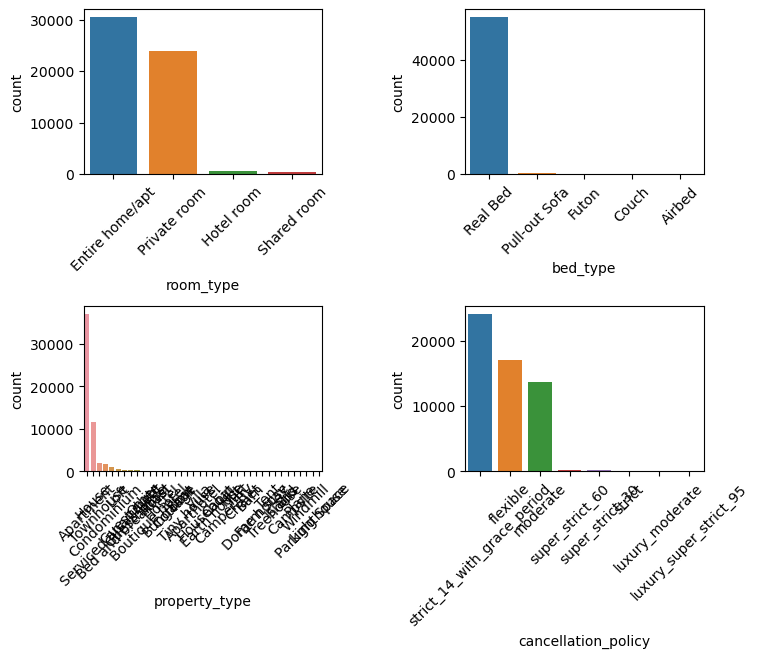

In [35]:
# Countplots for a better visualization

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,6))

sns.countplot(x='room_type', data=train, order=train.room_type.value_counts().index, ax=axes[0,0])
axes[0,0].tick_params(axis='x', rotation=45)

sns.countplot(x='bed_type', data=train, order=train.bed_type.value_counts().index, ax=axes[0,1])
axes[0,1].tick_params(axis='x', rotation=45)

sns.countplot(x='property_type', data=train, order=train.property_type.value_counts().index, ax=axes[1,0])
axes[1,0].tick_params(axis='x', rotation=45)

sns.countplot(x='cancellation_policy', data=train, order=train.cancellation_policy.value_counts().index, ax=axes[1,1])
axes[1,1].tick_params(axis='x', rotation=45)

plt.subplots_adjust(hspace=0.8, wspace=0.6)
plt.show()

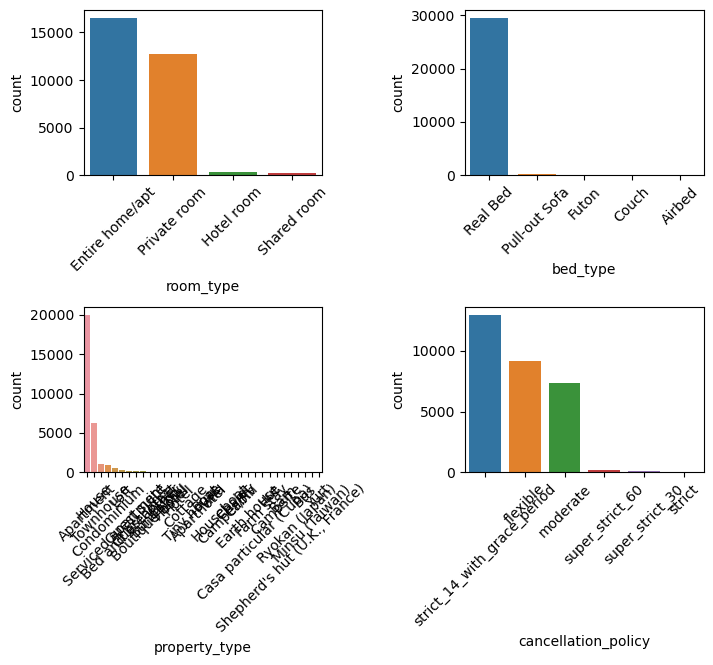

In [36]:
# Inspecting the distribution in the test set

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,6))

sns.countplot(x='room_type', data=test, order=test.room_type.value_counts().index, ax=axes[0,0])
axes[0,0].tick_params(axis='x', rotation=45)

sns.countplot(x='bed_type', data=test, order=test.bed_type.value_counts().index, ax=axes[0,1])
axes[0,1].tick_params(axis='x', rotation=45)

sns.countplot(x='property_type', data=test, order=test.property_type.value_counts().index, ax=axes[1,0])
axes[1,0].tick_params(axis='x', rotation=45)

sns.countplot(x='cancellation_policy', data=test, order=test.cancellation_policy.value_counts().index, ax=axes[1,1])
axes[1,1].tick_params(axis='x', rotation=45)

plt.subplots_adjust(hspace=0.8, wspace=0.6)

The same pattern is observed in both the training set and the test set:

In `room_type`, the two major categories are Entire home/apt and Private room, which account for 98% of the total listings. We therefore merge Hotel room and Shared room into one new category: Hotel/Share room   

In `bed_type`, the distribution is even more imbalanced: Real Bed with a proportion of 99% is the predominent category. It's reasonable to convert this feature to 'is_real_bed' with two values 1/0.  

In `property_type`, there're originally 36 categories, in which Apartment and House constitute 87% of the total listings. To circumvent the potential drawbacks of high cardinality, we regroup categories with counts lower than 500 into a new category: Others

In `cancellation_policy`, 99% of the total listing fall under the three primary policies: strict_14_with_grace_period, flexible, and moderate. For the remaining categories, we group them into a new one: super_strict (although the category luxury_moderate doesn't seem to fit, there's only 1 case in the training set, and none in the test set).

In [37]:
train.cancellation_policy.value_counts()

strict_14_with_grace_period    24102
flexible                       17094
moderate                       13643
super_strict_60                  230
super_strict_30                  211
strict                             2
luxury_moderate                    1
luxury_super_strict_95             1
Name: cancellation_policy, dtype: int64

In [38]:
test.cancellation_policy.value_counts()

strict_14_with_grace_period    12968
flexible                        9196
moderate                        7339
super_strict_60                  133
super_strict_30                  131
strict                             2
Name: cancellation_policy, dtype: int64

In [39]:
# Regrouping 'room_type', 'bed_type', 'property_type', and 'cancellation_policy'

train['room_type'] = train['room_type'].replace({'Hotel room': 'Hotel/Share room', 'Shared room': 'Hotel/Share room'})

train['bed_type'] = train['bed_type'].replace({'Pull-out Sofa': 'Not Real Bed', 'Futon': 'Not Real Bed',
                                               'Couch': 'Not Real Bed', 'Airbed': 'Not Real Bed'})
train['is_real_bed'] = train['bed_type'].apply(lambda x: 1 if x == 'Real Bed' else 0).astype('int64')
train = train.drop(columns=['bed_type'])

property_counts_dict = train['property_type'].value_counts().to_dict()
train['property_type'] = train['property_type'].apply(lambda x: 'Others' if property_counts_dict[x] < 500 else x)

train['cancellation_policy'] = train['cancellation_policy'].replace({'super_strict_30': 'super_strict', 
                                                                    'super_strict_60': 'super_strict',
                                                                    'strict': 'super_strict',
                                                                    'luxury_moderate': 'super_strict', 
                                                                    'luxury_super_strict_95': 'super_strict'})

In [40]:
# Convert 'room_type', 'property_type', 'cancellation_policy' to category

to_cat = ['room_type', 'property_type', 'cancellation_policy']

for col in to_cat:
    train[col] = train[col].astype('category')

In [41]:
# Apply to test set

test['room_type'] = test['room_type'].replace({'Hotel room': 'Hotel/Share room', 'Shared room': 'Hotel/Share room'})

test['bed_type'] = test['bed_type'].replace({'Pull-out Sofa': 'Not Real Bed', 'Futon': 'Not Real Bed',
                                               'Couch': 'Not Real Bed', 'Airbed': 'Not Real Bed'})
test['is_real_bed'] = test['bed_type'].apply(lambda x: 1 if x == 'Real Bed' else 0).astype('int64')
test = test.drop(columns=['bed_type'])

property_counts_dict = test['property_type'].value_counts().to_dict()
test['property_type'] = test['property_type'].apply(lambda x: 'Others' if property_counts_dict[x] < 500 else x)

test['cancellation_policy'] = test['cancellation_policy'].replace({'super_strict_30': 'super_strict', \
                                                                    'super_strict_60': 'super_strict',
                                                                    'strict': 'super_strict'})

to_cat = ['room_type', 'property_type', 'cancellation_policy']

for col in to_cat:
    test[col] = test[col].astype('category')

* * * 
**`amenities`** denotes the provided facilities. We choose to convert this variable into a numeric one, representing the number of amenities a property provides. 
 
Upon analyzing the original values in both training and test set, we identify the pattern as amenities being delimited by commas, enclosed within a pair of square brackets.    

`translation missing: en.hosting_amenity_49` and `translation missing: en.hosting_amenity_50` appear quite often. We intereprete them as two types of facilities, not shown correctlay due to potential translation error. Therefore, we include them into the amenities count.

In [42]:
train['amenities'][0]

'{Wifi,"Paid parking off premises",Heating,Washer,"Smoke detector","Carbon monoxide detector","First aid kit",Essentials,Shampoo,Hangers,"Hair dryer",Iron,"Laptop friendly workspace","translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50","Hot water","Bed linens","Extra pillows and blankets","Dishes and silverware","Luggage dropoff allowed","Host greets you","Handheld shower head"}'

In [43]:
# Remove square brackets
train['amenities'] = train['amenities'].str.strip('{}')

# Count the number of amenities each listing offers
train['num_of_amenities'] = train['amenities'].str.count(',') + 1
train = train.drop('amenities', axis=1)

In [44]:
# Apply to test set
test['amenities'] = test['amenities'].str.strip('{}')

test['num_of_amenities'] = test['amenities'].str.count(',') + 1
test = test.drop('amenities', axis=1)

* * * 
**`neighbourhood_cleansed` and `neighbourhood`** need to be converted to category:

In [45]:
train[['neighbourhood_cleansed', 'neighbourhood']] = train[['neighbourhood_cleansed', 'neighbourhood']].astype('category')
test[['neighbourhood_cleansed', 'neighbourhood']] = test[['neighbourhood_cleansed', 'neighbourhood']].astype('category')

How to encode these two features with many categories necessitates careful analysis. For example, 'neighbourhood_cleansed' comprises 33 distinct categories. The issue of high cardinality thus becomes a significant consideration.  

In general, there are 3 major ways of handling categorical variables: one-hot encoding, label encoding, and target encoding.  

We choose not to apply label encoding since it would introduce an implicit order that is absent in the original data. Target encoding wouldn't result in high cardinality like one-hot encoding does, but it makes model prone to overfit due to target leakage. We thus decide to compare the effects of one-hot encoding versus target encoding by checking model performance of a Random Forest Regressor utilizing only `neighbourhood_cleansed`.  

In [46]:
# Randon Forest Regressor with one-hot encoded 'neighbourhood_cleansed'

X_train, X_test, y_train, y_test = train_test_split(train['neighbourhood_cleansed'], train['price'], test_size=0.20, random_state=123)

X_train_dum = pd.get_dummies(X_train)
X_test_dum = pd.get_dummies(X_test)

rf_model = RandomForestRegressor(n_estimators=100, max_samples = 0.5, random_state=123, verbose=0)
rf_model.fit(X_train_dum, y_train)

prediction = rf_model.predict(X_test_dum)

mse = mean_squared_error(y_test, prediction)
mae = mean_absolute_error(y_test, prediction)

print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 6376.06149658109
MAE: 55.66785594157668


In [47]:
# Target encoding 'neighbourhood_cleansed'

train_copy = train.copy()

# Smoothing parameter
alpha = 1.0

# Use KFold for performing K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=123)

encoded_neighbourhood = []

for train_index, val_index in kf.split(train_copy):
    # Split the dataset into training and validation sets based on cross-validation indices
    train_fold, val_fold = train_copy.iloc[train_index], train_copy.iloc[val_index]
    # Calculate the mean target variable for each category
    class_counts = train_fold['neighbourhood_cleansed'].value_counts()
    class_means = train_fold.groupby('neighbourhood_cleansed')['price'].mean()
    smoothed_encoding = (class_means * class_counts + alpha) / (class_counts + alpha)
    # Use the smoothed values to encode categories in the validation set, and add the encoding values to the list
    encoding = val_fold['neighbourhood_cleansed'].map(smoothed_encoding)
    encoded_neighbourhood.extend(encoding)

train_copy['neighbourhood_encoded'] = encoded_neighbourhood


In [48]:
# Randon Forest Regressor with target encoded 'neighbourhood_cleansed'

X_train, X_test, y_train, y_test = train_test_split(train_copy[['neighbourhood_encoded']], train_copy['price'], test_size=0.20, random_state=111)

rf_model = RandomForestRegressor(n_estimators=100, max_samples = 0.5, random_state=123, verbose=0)
rf_model.fit(X_train, y_train)

prediction = rf_model.predict(X_test)

mse = mean_squared_error(y_test, prediction)
mae = mean_absolute_error(y_test, prediction)

print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 6780.896679402581
MAE: 59.0558908389101


Looking at the results, even with the implementation of regularized target encoding to mitigate overfitting, the model performance is still worse than that achieved with one-hot encoded `neighbourhood_cleansed`.  

Given that our final model employs a neural network based deep learning architecture, which should be capable of handling large number of features, we choose to one-encode `neighbourhood_cleansed`, which will be implemented later.

* * * 
### 3.3 Feature Selection

Upon examing the distribution of categories within **`experiences_offered`**, we find that most listings are under category `none`. The same holds true in the test set.  

Given the prevalence of `none` cases, we conclude that this variable isn't informative, and decide not to include it into our consideration.

Number of cases where 'experiences_offered' is 'none' in training set: 54222
Number of cases where 'experiences_offered' is 'none' in test set: 29194


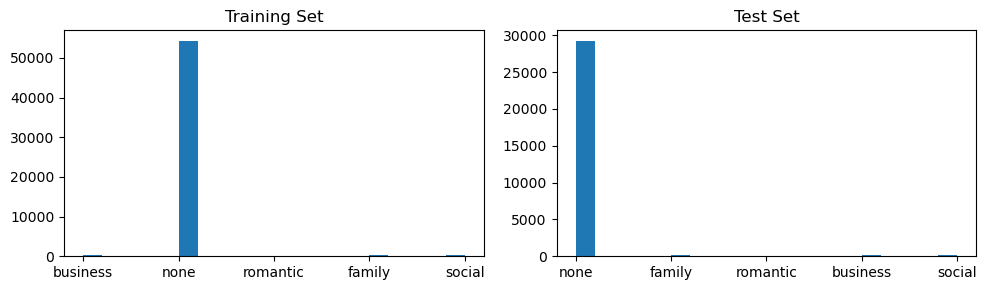

In [49]:
print("Number of cases where 'experiences_offered' is 'none' in training set:", (train['experiences_offered'] == 'none').sum())
print("Number of cases where 'experiences_offered' is 'none' in test set:", (test['experiences_offered'] == 'none').sum())

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].hist(train.experiences_offered, bins=20)
axs[0].set_title('Training Set')

axs[1].hist(test.experiences_offered, bins=20)
axs[1].set_title('Test Set')

plt.tight_layout()
plt.show()

* * * 
**`accommodates` and `guests_included`** convey essentially the same information. We assume that the former refers to a property's capacity, while the latter represents the actual number of guests that a property has accommodated.   

Upon comparing values of these two features row-wisely, our guess appears to be valid. There are indeed some cases where the value of `accommodates` is lower than `guests_included`, but it shouldn't undermine the fundamental similarity in the information conveyed by these features.  

Given that, coupled with the fact that neither features contain missing values, we choose to keep `accommodates`.

In [50]:
check_accom_guest = train['accommodates'] >= train['guests_included']
print(check_accom_guest)
print("\n")
print("Number of cases where 'accommodates' is larger than 'guests_included':", sum(check_accom_guest))

0        True
1        True
2        True
3        True
4        True
         ... 
55279    True
55280    True
55281    True
55282    True
55283    True
Length: 55284, dtype: bool


Number of cases where 'accommodates' is larger than 'guests_included': 54948


* * * 
**`zipcode`, `longitude`, and `latitude`** provide geographical information that is overly detailed for our prediction task. Instead, focusing on a borough-level granularity is likely sufficient.  

**`neighbourhood_cleansed`** encapsulates the administrative units in **`neighbourhood`**. We thus decide to include `neighbourhood_cleansed` in our range of selection.

In [51]:
train.loc[17,['neighbourhood_cleansed', 'neighbourhood']]

neighbourhood_cleansed    Kensington and Chelsea
neighbourhood                            Chelsea
Name: 17, dtype: object

***
To identify non-text features with predictive power, we explore various methods.

**Correlation matrix for detecting correlation and possible multicollinearity:**

<Axes: >

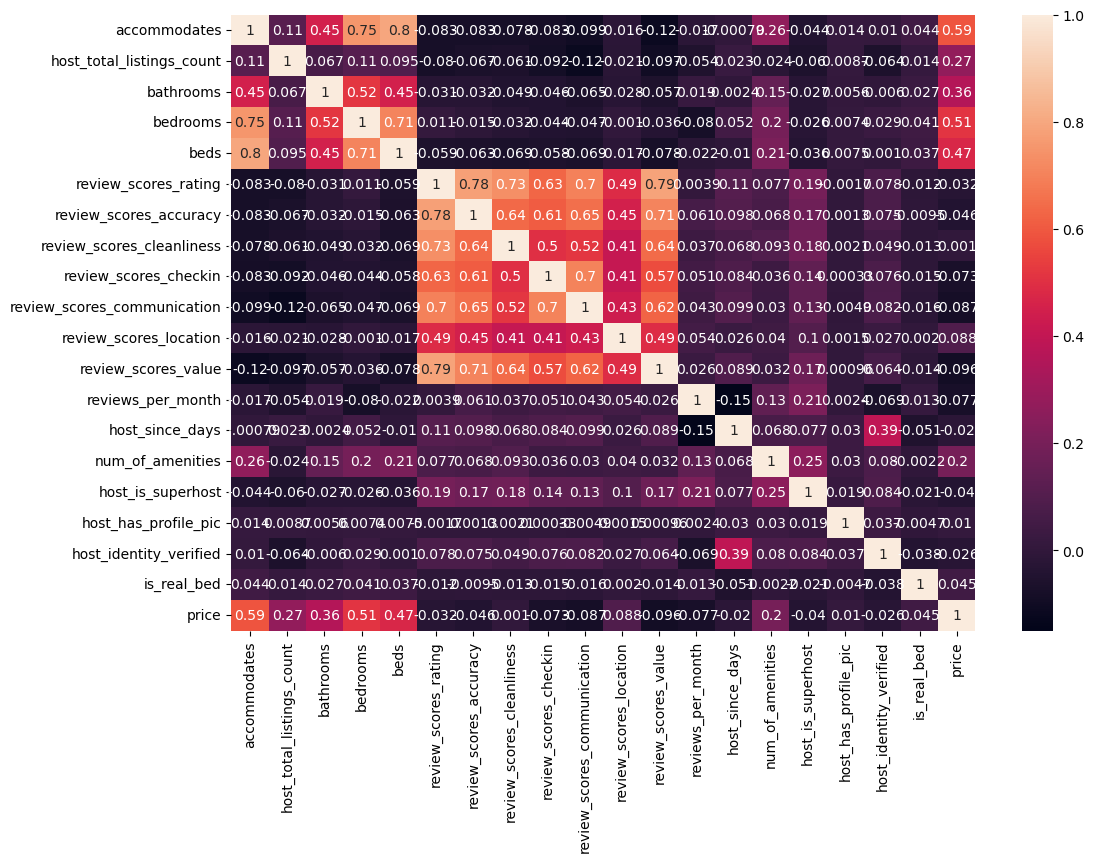

In [53]:
continuous = ['accommodates', 'host_total_listings_count', 'bathrooms', 'bedrooms', 'beds', 'review_scores_rating', 'review_scores_accuracy',
            'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value',
            'reviews_per_month', 'host_since_days', 'num_of_amenities']

binary = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'is_real_bed']

struc_data = train[continuous + binary].copy()
struc_data['price'] = train['price']

cor = struc_data.corr()
plt.figure(figsize=(12,8))
sns.heatmap(cor, annot=True)

Based on the heatmap, we have two findings: 

First, `accommodates`, `beds`, `bedrooms`, and `bathrooms`  exhibit relatively strong correlations with the 'price' variable, but they also demonstrate substantial intercorrelations among themselves.  

Second, high correlation is also found among `review_scores_rating`, `review_scores_accuracy`, `review_scores_cleanliness`, `review_scores_checkin`, `review_scores_communication`, `review_scores_location`, and `review_scores_value`.  

To mitigate the risk of multicollinearity, we decide to conduct PCA analysis on these two groups of correlated features, converting each group into one feature.  

In [54]:
def apply_pca(data, features, prefix):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(data[features])

    pca = PCA(n_components=1)
    principal_components = pca.fit_transform(scaled)
    
    data[prefix] = principal_components

apply_pca(train, ['accommodates', 'beds', 'bedrooms', 'bathrooms'], 'accom_room')

apply_pca(train, ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value'], 'review_scores')


In [55]:
# Apply to test set
apply_pca(test, ['accommodates', 'beds', 'bedrooms', 'bathrooms'], 'accom_room')
apply_pca(test, ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value'], 'review_scores')


*** 

**Ordinary Least Squares for checking feature importance:**

In [56]:
struc_data_new = ['neighbourhood_cleansed', 'property_type', 'room_type', 'cancellation_policy', 'host_is_superhost', 'host_total_listings_count', 'host_has_profile_pic',
                'host_identity_verified', 'reviews_per_month', 'host_since_days', 'is_real_bed', 'num_of_amenities', 'accom_room', 'review_scores']

to_scale = ['host_total_listings_count', 'reviews_per_month', 'host_since_days', 'num_of_amenities'] # the two newly generated principal components are excluded (already standardized during PCA analysis) 

X = train[struc_data_new]
y = train['price']

standard = StandardScaler()
X_scaled = X.copy()
X_scaled[to_scale] = standard.fit_transform(X_scaled[to_scale])

X_scaled_dum = pd.get_dummies(X_scaled)

import statsmodels.api as sm

X_scaled_dum = sm.add_constant(X_scaled_dum)

model = sm.OLS(y, X_scaled_dum)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     1261.
Date:                Mon, 28 Aug 2023   Prob (F-statistic):               0.00
Time:                        22:27:55   Log-Likelihood:            -3.0159e+05
No. Observations:               55284   AIC:                         6.033e+05
Df Residuals:                   55231   BIC:                         6.038e+05
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

We can conclude that the principal component `accom_room` is of great importance for predicting price. `host_total_listings_count` and `is_real_bed` are also statistically significant predictors of price.

On the other hand, some features seem to be insignificant or have a small impact on price: `host_has_profile_pic`, `host_is_superhost` etc.

The warning of the presence of multicollinearity is most likely due to dummy variables.
***  

**Random Forest for getting feature importance:**

In [57]:
X = train[struc_data_new]
y = train['price']

X_dum = pd.get_dummies(X)

rf_fea_imp = RandomForestRegressor(n_estimators=100, max_samples = 0.5, random_state=123, verbose=0)
rf_fea_imp.fit(X_dum, y)

feature_importance = rf_fea_imp.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_dum.columns, 'Importance': feature_importance}).sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                                            Feature  Importance
8                                        accom_room    0.283028
51                           room_type_Private room    0.166169
1                         host_total_listings_count    0.084955
5                                   host_since_days    0.075150
4                                 reviews_per_month    0.063541
7                                  num_of_amenities    0.060653
9                                     review_scores    0.055588
49                        room_type_Entire home/apt    0.041696
42               neighbourhood_cleansed_Westminster    0.029488
29    neighbourhood_cleansed_Kensington and Chelsea    0.022634
15                    neighbourhood_cleansed_Camden    0.009438
3                            host_identity_verified    0.007360
45                              property_type_House    0.006109
54  cancellation_policy_strict_14_with_grace_period    0.005708
52                     cancellation_poli

In the feature importance list generated by Random Forest, `accom_room` and `host_total_listings_count` remain important, but the others are somewhat difficult to interpret, especially those dummy variables.
***  

**Lasso regression for feature selection:**

In [58]:
X = train[struc_data_new]
y = train['price']

X_dum = pd.get_dummies(X)

lasso = Lasso(alpha=1.0)
lasso.fit(X_dum, y)

features_nonzero = X_dum.columns[lasso.coef_ != 0]

print("Features whose coefficients are non-zero:", features_nonzero)

Features whose coefficients are non-zero: Index(['host_total_listings_count', 'reviews_per_month', 'host_since_days',
       'num_of_amenities', 'accom_room', 'review_scores',
       'neighbourhood_cleansed_Camden',
       'neighbourhood_cleansed_Kensington and Chelsea',
       'neighbourhood_cleansed_Westminster', 'property_type_House',
       'room_type_Entire home/apt', 'room_type_Private room'],
      dtype='object')


The penalty term in Lasso Regression makes some feature coefficients to become exactly zero during model training. This leads to automatic feature selection as the model prefers simpler solutions with fewer non-zero coefficients, effectively removing less important features. 

Based on the results of Lasso Regression, `host_total_listings_count`, `reviews_per_month`, `host_since_days`, `num_of_amenities`, `accom_room`,  `review_scores` seem to remain important even with the penalty term being set to 1.
***  

**Inspecting multi-level categorical features by utilizing only one feature each time for predicting price:**

In [59]:
multi_level = ['neighbourhood_cleansed', 'property_type', 'room_type', 'cancellation_policy']

X = train[multi_level]
y = train['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

X_train_dum = pd.get_dummies(X_train)
X_test_dum = pd.get_dummies(X_test)

rf_mul_lev = RandomForestRegressor(n_estimators=100, random_state=123)

# Evaluate each feature's importance using Random Forest
for var in multi_level:
    # Filter columns related to the current feature
    relevant_cols = [col for col in X_train_dum.columns if col.startswith(var)]
    X_train_var = X_train_dum[relevant_cols]
    X_test_var = X_test_dum[relevant_cols]

    rf_mul_lev.fit(X_train_var, y_train)

    y_pred = rf_mul_lev.predict(X_test_var)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Variable: {var}")
    print(f"MSE: {mse}")
    print(f"R^2: {r2}")
    print()


Variable: neighbourhood_cleansed
MSE: 6375.717787108872
R^2: 0.1387105793212563

Variable: property_type
MSE: 7314.9411234182035
R^2: 0.011831826178601346

Variable: room_type
MSE: 5317.0961058755565
R^2: 0.2817187369895484

Variable: cancellation_policy
MSE: 6939.8430698778475
R^2: 0.06250345187143103



By using only one multi-level categorical feature each time in a Random Forest model to predict price, we notice that `neighbourhood_cleansed` and `room_type` have relatively lower MSE and higher R-square value.

After trying out different methods of feature selection, and based on our common sense, we decide to utilize **`accom_room`, `host_total_listings_count`, `reviews_per_month`, `is_real_bed`, `num_of_amenities`, `neighbourhood_cleansed`, `room_type`** among non-text features. 

* * * 

### 3.4 Preprocessing of Text Data

By eyeballing the text features, it's noticed that  the content present in `summary`, `space`, `description`, `neighborhood_overview`, and `transit` often time overlaps, with `description` containing mostly the longest text.  

We decide to investigate how often the information in other text variables is incorporated in `descriotion`, and reduce redundancy by merging them together.   

In [60]:
count_summary_in_description = train.apply(lambda row: 
    1 if pd.notnull(row['summary']) and pd.notnull(row['description']) and row['summary'] in row['description'] else 0, axis=1).sum()

count_space_in_description = train.apply(lambda row: 
    1 if pd.notnull(row['space']) and pd.notnull(row['description']) and row['space'] in row['description'] else 0, axis=1).sum()

count_neighover_in_description = train.apply(lambda row: 
    1 if pd.notnull(row['neighborhood_overview']) and pd.notnull(row['description']) and row['neighborhood_overview'] in row['description'] else 0, axis=1).sum()

count_transit_in_description = train.apply(lambda row: 
    1 if pd.notnull(row['transit']) and pd.notnull(row['description']) and row['transit'] in row['description'] else 0, axis=1).sum()

count_name_in_description = train.apply(lambda row: 
    1 if pd.notnull(row['name']) and pd.notnull(row['description']) and row['name'] in row['description'] else 0, axis=1).sum()

count_rules_in_description = train.apply(lambda row: 
    1 if pd.notnull(row['house_rules']) and pd.notnull(row['description']) and row['house_rules'] in row['description'] else 0, axis=1).sum()


print("Number of rows where summary is in description:", count_summary_in_description)
print("Number of rows where space is in description:", count_space_in_description)
print("Number of rows where neighborhood_overview is in description:", count_neighover_in_description)
print("Number of rows where transit is in description:", count_transit_in_description)
print("Number of rows where name is in description:", count_name_in_description)
print("Number of rows where house_rules is in description:", count_rules_in_description)


Number of rows where summary is in description: 52130
Number of rows where space is in description: 26045
Number of rows where neighborhood_overview is in description: 11114
Number of rows where transit is in description: 8257
Number of rows where name is in description: 505
Number of rows where house_rules is in description: 35


Given the substantial number of cases where **`summary`** is encompassed within `description`, we conclude that these two features are highly identical, and choose to keep only `description` among them.  

**`space`, `neighborhood_overview`, and `transit`** incorporate more additional information that is not included in `description`. We chose to merge them to `description` and replace text that is already in `description`.   

Although **`name`** overlaps less frequently with 'description', it is essentially just the condensed version of other text features. Keeping it wouldn't contribute much new information.   
Additionally, according to our intuitive understanding, **`house_rules`** doesn't display a notably strong correlation with price and lacks predictive power in this context. The presence of numerous rules or stringent rules doesn't necessarily signify a higher/lower price for a property.   
Therefore, we decide to not to include `name` and `house_rules`.  

(side note: the above trend is also found in test set, so it's reasonable to apply the same procedures to test set)

In [61]:
# Replace text that is included in description

train['space'] = train.apply(lambda row: row['space'].replace(row['space'], '') \
    if pd.notnull(row['space']) and pd.notnull(row['description']) and row['space'] in row['description'] else row['space'], axis=1)

train['neighborhood_overview'] = train.apply(lambda row: row['neighborhood_overview'].replace(row['neighborhood_overview'], '') \
    if pd.notnull(row['neighborhood_overview']) and pd.notnull(row['description']) and row['neighborhood_overview'] in row['description'] else row['neighborhood_overview'], axis=1)

train['transit'] = train.apply(lambda row: row['transit'].replace(row['transit'], '') \
    if pd.notnull(row['transit']) and pd.notnull(row['description']) and row['transit'] in row['description'] else row['transit'], axis=1)

# Fill missing values with an empty string
text_col_to_fill = ['space', 'neighborhood_overview', 'transit']
train[text_col_to_fill] = train[text_col_to_fill].fillna('')

# Merge them into description
train['description_merged'] = train['space'] + ' ' + train['description'] + ' ' + train['neighborhood_overview'] + ' ' + train['transit']

# Drop the original columns
train = train.drop(columns=['space', 'neighborhood_overview', 'transit', 'description'])

In [62]:
# Apply to test set

test['space'] = test.apply(lambda row: row['space'].replace(row['space'], '') \
    if pd.notnull(row['space']) and pd.notnull(row['description']) and row['space'] in row['description'] else row['space'], axis=1)

test['neighborhood_overview'] = test.apply(lambda row: row['neighborhood_overview'].replace(row['neighborhood_overview'], '') \
    if pd.notnull(row['neighborhood_overview']) and pd.notnull(row['description']) and row['neighborhood_overview'] in row['description'] else row['neighborhood_overview'], axis=1)

test['transit'] = test.apply(lambda row: row['transit'].replace(row['transit'], '') \
    if pd.notnull(row['transit']) and pd.notnull(row['description']) and row['transit'] in row['description'] else row['transit'], axis=1)

test[text_col_to_fill] = test[text_col_to_fill].fillna('')

test['description_merged'] = test['space'] + ' ' + test['description'] + ' ' + test['neighborhood_overview'] + ' ' + test['transit']

test = test.drop(columns=['space', 'neighborhood_overview', 'transit', 'description'])

* * * 

Next, we perform some standard steps of text cleaning:

In [63]:
# Remove whitespace

def remove_whitespace(text):
    """ Function to remove whitespace (tabs, newlines). """
    return ' '.join(text.split())

In [64]:
# Remove all non-alphanumeric characters, and lowercasing all words

def remove_nonalpha_and_casing(text):
    """
    Function to remove the punctuation and words that include
    non-alphanumeric characters.
    """
    text = ' '.join([word.lower() for word in text.split()]) 
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)
    return text

In [65]:
# Lemmatize with POS Tag

def get_wordnet_pos(word):
    """Helper function that calls the POS tagger for an input word and return a code that can be used for lemmatization"""
    # Extract the first letter of the POS tag
    tag = nltk.pos_tag([word])[0][1][0].upper()  
    # Dictionary to map these letters to wordnet codes that the lemmatizer understands
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [66]:
def text_cleaning(series):
    """ Function for standard NLP pre-processing """
    lemmatizer = WordNetLemmatizer()
    cleaned_column = [] 

    for doc in series:
        if isinstance(doc, str):
            # remove html content
            text = BeautifulSoup(doc, "html.parser").get_text()
            # remove whitespaces
            text = remove_whitespace(text)
            # remove all non-alphanumeric characters, and lowercasing all words
            text = remove_nonalpha_and_casing(text)
            # tokenize the text
            tokenized_words = word_tokenize(text)
            # remove stopwords
            filtered_words = [w for w in tokenized_words if w not in stopwords.words("english")]
            # lemmatize each word
            lemma_words = [lemmatizer.lemmatize(i, get_wordnet_pos(i)) for i in filtered_words]
            # rejoin lemmatized words together
            text = ' '.join([w for w in lemma_words])
            cleaned_column.append(text) 
        else:
            cleaned_column.append(None)

    return pd.Series(cleaned_column)

In [48]:
train['description_merged_cleaned'] = text_cleaning(train['description_merged'])
test['description_merged_cleaned'] = text_cleaning(test['description_merged'])

/tmp/ipykernel_1145/1751155705.py:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(doc, "html.parser").get_text()
/tmp/ipykernel_1145/1751155705.py:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(doc, "html.parser").get_text()


In [49]:
train['description_merged_cleaned'][:10]

0    double room available historic royal greenwich...
1    garden studio private entrance 5 minute crouch...
2                                                 None
3    luxury first floor victorian split level maiso...
4    modern well equip cosy apartment close victori...
5    hello 2 bedroom garden flat south east london ...
6    luxurious two double bedroom apartment situate...
7    spacious private living room fantastic central...
8                                                 None
9    amaze comfortable specious double room perfect...
Name: description_merged_cleaned, dtype: object



* * *

## 4. Model Selection
### 4.1 Benchmark Models  
In order to gauge the predictive power of text data and the performance of our ultimate model, we experiment with some benchmark models for comparison.
#### 4.1.1 Linear Regression for non-text features 
Since Linear Regression is sensitive to the scales of data, we standardize numeric features before fitting our model to it.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(train[['neighbourhood_cleansed', 'room_type', 'host_total_listings_count', 'reviews_per_month', 'is_real_bed', 'num_of_amenities', 'accom_room']], train['price'], test_size=0.20, random_state=123)

scaler = StandardScaler()
X_train_scl = X_train
X_test_scl = X_test
to_scale = ['host_total_listings_count', 'reviews_per_month', 'num_of_amenities'] # 'accom_room' is excluded since it's standardized in PCA analysis; 'is_real_bed' is also excluded since it's binary
X_train_scl[to_scale] = scaler.fit_transform(X_train[to_scale])
X_test_scl[to_scale] = scaler.transform(X_test[to_scale])

X_train_scl_dum = pd.get_dummies(X_train_scl, columns=['neighbourhood_cleansed', 'room_type'])
X_test_scl_dum = pd.get_dummies(X_test_scl, columns=['neighbourhood_cleansed', 'room_type'])

regression = LinearRegression()
regression.fit(X_train_scl_dum, y_train)

prediction = regression.predict(X_test_scl_dum)
r2 = regression.score(X_test_scl_dum, y_test)
mse = mean_squared_error(y_test, prediction)
mae = mean_absolute_error(y_test, prediction)

print(f"R2: {r2}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

R2: 0.5417062307693035
MSE: 3392.53178554389
MAE: 36.43912368861355


Our model is able to explain approximately 54% of the price variance, which is a reasonably acceptable outcome. Based on the MSE and MAE values, the model's predictions are moderately accurate, but there is definitely room for improvement. We expect that more complex models might be able to enhance predictive performance further.

#### 4.1.2 Random Forest for non-text features   
In contrast, tree-based model is less vulnerable to unscaled data. We thus save the step of standardization.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(train[['neighbourhood_cleansed', 'room_type', 'host_total_listings_count', 'reviews_per_month', 'is_real_bed', 'num_of_amenities', 'accom_room']], train['price'], test_size=0.20, random_state=123)

X_train_dum = pd.get_dummies(X_train, columns=['neighbourhood_cleansed', 'room_type'])
X_test_dum = pd.get_dummies(X_test, columns=['neighbourhood_cleansed', 'room_type'])

rf_model = RandomForestRegressor(n_estimators=100, max_samples = 0.5, random_state=123, verbose=0)
rf_model.fit(X_train_dum, y_train)

prediction = rf_model.predict(X_test_dum)

r2 = r2_score(y_test, prediction)
mse = mean_squared_error(y_test, prediction)
mae = mean_absolute_error(y_test, prediction)

print(f"R-square: {r2}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

R-square: 0.6141606189849187
MSE: 2856.1862545186173
MAE: 33.22282024746228


As for R-square, there is an improvement compared to the linear regression model, indicating that the Random Forest model captures more of the underlying patterns in the data. Both MSE and MAE values are lower as well, suggesting more accurate predictions. Overall, the Random Forest model outperforms the Linear Regression Model.


#### 4.1.3 LightGBM for non-text features  
One advantage of LightGBM is its ability to work with categorical features directly using the `categorical_feature` parameter. This avoids the need for one-hot encoding, which can greatly increase the dimensionality of the data and subsequently consume more memory and computational resources.     

The "Gradient-based One-Side Sampling" technique enables LightGBM to deal with large number of categories efficiently by down-sampling the gradient statistics of large gradients, which often correspond to infrequent categories. This leads to reduced computation time and improved performance when dealing with high-cardinality categorical features.  

In our case, the presence of the feature `neighbourhood_cleansed` with 33 categories makes LightGBM an attractive option. 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(train[['neighbourhood_cleansed', 'room_type', 'host_total_listings_count', 'reviews_per_month', 'is_real_bed', 'num_of_amenities', 'accom_room']], train['price'], test_size=0.2, random_state=123)

# Create a LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=['neighbourhood_cleansed', 'room_type'])

params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt', # traditional Gradient Boosting Decision Tree
    'num_leaves': 31, 
    'learning_rate': 0.2,
    'feature_fraction': 0.9
}

model = lgb.train(params, train_data, num_boost_round=100)

prediction = model.predict(X_test)

r2 = r2_score(y_test, prediction)
mse = mean_squared_error(y_test, prediction)
mae = mean_absolute_error(y_test, prediction)

print(f"R-square: {r2}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 721
[LightGBM] [Info] Number of data points in the train set: 44227, number of used features: 7
[LightGBM] [Info] Start training from score 104.168720
R-square: 0.6361310040570723
MSE: 2693.5498961342632
MAE: 32.14333339625191


The performance of the LightGBM model is even better than that of the Random Forest model. We then perform a 10-fold cross-validation to further evaluate its performance:  

In [27]:
# 10-fold cross-validation for LightGBM

train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=['neighbourhood_cleansed', 'room_type'])

params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt', # traditional Gradient Boosting Decision Tree
    'num_leaves': 31, 
    'learning_rate': 0.2,
    'feature_fraction': 0.9
}

cv_results = lgb.cv(params, train_data, num_boost_round=100, nfold=10, shuffle=True, metrics=['mse', 'mae'], stratified=False)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 721
[LightGBM] [Info] Number of data points in the train set: 39798, number of used features: 7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 721
[LightGBM] [Info] Number of data points in the train set: 39798, number of used features: 7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 721
[LightGBM] [Info] Number of data points in the train set: 39798, number of used features: 7
[L

In [29]:
cv_results.keys()

dict_keys(['valid l2-mean', 'valid l2-stdv', 'valid l1-mean', 'valid l1-stdv'])

In [28]:
average_mse = np.mean(cv_results['valid l2-mean']) # l2 in LightGBM is MSE
average_mae = np.mean(cv_results['valid l1-mean']) # l1 in LightGBM is MAE

print(f'Average MSE: {average_mse:.4f}')
print(f'Average MAE: {average_mae:.4f}')

Average MSE: 2864.7175
Average MAE: 33.1756


We observe a large drop in the model's performance, which indicates potential risks of overfitting. 

#### 4.1.4 Basic GRU for text features
In order to gain some insights into the predictive power of the text data, we set up a Basic GRU model with self-training embeddings. We then take the output of the GRU model as a new feature for a Random Forest Regressor and make predictions based on this new feature and other structural data.

For the loss function,  our selection is log-cosh, as it works like MSE but is more robust to outliers. It penalizes large errors less severely, making it better suited for our case where there are many outliers in the target variable.

In [32]:
cat_feas = ['neighbourhood_cleansed', 'room_type']

num_feas = ['accom_room', 'host_total_listings_count', 'reviews_per_month', 'is_real_bed', 'num_of_amenities']

text_feas = ['description_merged_cleaned']

target = ['price']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(train[cat_feas + num_feas + text_feas], train[target], test_size=0.20, random_state=123)

# Preparing text data
X_train_text = np.squeeze(X_train[text_feas].values).tolist()
X_test_text = np.squeeze(X_test[text_feas].values).tolist()

X_train_text = [text if text and not pd.isna(text) else "" for text in X_train_text]
X_test_text = [text if text and not pd.isna(text) else "" for text in X_test_text]

# One-hot encoding categorical features
X_train = pd.get_dummies(X_train, columns = cat_feas)
X_test = pd.get_dummies(X_test, columns = cat_feas)

# Scaling numeric features
to_scale = ['host_total_listings_count', 'reviews_per_month', 'num_of_amenities'] # 'is_real_bed' is a binary feature, and 'accom_room' is the principal component, therefore both are excluded
standard_scaler = StandardScaler()
X_train[to_scale] = standard_scaler.fit_transform(X_train[to_scale])
X_test[to_scale] = standard_scaler.transform(X_test[to_scale])

y_train_text = np.squeeze(y_train.values)
y_test_text = np.squeeze(y_test.values)

In [36]:
# Tokenization

maxlen = 400

tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_text)

X_train_text_seq = tokenizer.texts_to_sequences(X_train_text)
X_train_text_pad = pad_sequences(X_train_text_seq, maxlen)

X_test_text_seq = tokenizer.texts_to_sequences(X_test_text)
X_test_text_pad = pad_sequences(X_test_text_seq, maxlen)

max_text_len = max([len(text) for text in X_train_text_seq])
print('The longest text of the training set has {} words.'.format(max_text_len))

vocab_size = len(tokenizer.word_index) + 1
print('Found %s unique tokens in the training set.' % vocab_size)

print('Shape of training text data:', X_train_text_pad.shape)

The longest text of the training set has 736 words.
Found 38662 unique tokens in the training set.
Shape of training text data: (44227, 400)


In [37]:
# GRU model with only text data

input_text = Input(shape=(400, ))

input_embed = Embedding(input_dim=vocab_size, output_dim=100, input_length=400)(input_text)
gru_text = GRU(128, return_sequences=False)(input_embed)
gru_out = Dense(1, activation='linear')(gru_text) # activation function is linear since we'll use the output to generate final predictions

gru = Model(inputs=input_text, outputs=gru_out)
gru.compile(loss=losses.LogCosh(), optimizer='adam', metrics=['mae', 'mse'])
print(gru.summary())

callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=0.01, restore_best_weights=True)]

story = gru.fit(X_train_text_pad, y_train, epochs=10, verbose=1, batch_size=256, validation_split=0.2, callbacks=callbacks)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400)]             0         
                                                                 
 embedding (Embedding)       (None, 400, 100)          3866200   
                                                                 
 gru (GRU)                   (None, 128)               88320     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 3,954,649
Trainable params: 3,954,649
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10


2023-08-29 23:45:31.221423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-29 23:45:31.223046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-29 23:45:31.223990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

139/139 [==============================] - ETA: 0s - loss: 82.1866 - mae: 82.8748 - mse: 13804.4707

2023-08-29 23:49:36.654512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-29 23:49:36.656073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-29 23:49:36.657073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

139/139 [==============================] - 263s 2s/step - loss: 82.1866 - mae: 82.8748 - mse: 13804.4707 - val_loss: 70.4908 - val_mae: 71.1787 - val_mse: 11713.6602
Epoch 2/10
139/139 [==============================] - 253s 2s/step - loss: 67.0470 - mae: 67.7325 - mse: 10971.3164 - val_loss: 61.9734 - val_mae: 62.6622 - val_mse: 9934.1641
Epoch 3/10
139/139 [==============================] - 252s 2s/step - loss: 61.0050 - mae: 61.6916 - mse: 9563.0107 - val_loss: 58.1970 - val_mae: 58.8860 - val_mse: 8900.3184
Epoch 4/10
139/139 [==============================] - 253s 2s/step - loss: 58.1529 - mae: 58.8394 - mse: 8709.5537 - val_loss: 56.3698 - val_mae: 57.0596 - val_mse: 8252.4346
Epoch 5/10
139/139 [==============================] - 254s 2s/step - loss: 56.7300 - mae: 57.4180 - mse: 8175.6738 - val_loss: 55.5358 - val_mae: 56.2262 - val_mse: 7850.7520
Epoch 6/10
139/139 [==============================] - 253s 2s/step - loss: 56.0678 - mae: 56.7555 - mse: 7842.4067 - val_loss: 55.226

In [41]:
# Interim prediction
X_test_text_gru = gru.predict(X_test_text_pad)
print(f"Text MSE: {mean_squared_error(X_test_text_gru, y_test)}")
print(f"Text MAE: {mean_absolute_error(X_test_text_gru, y_test)}") 

346/346 [==============================] - 18s 51ms/step
Text MSE: 8075.42289581403
Text MAE: 57.27933165198415


The text data alone doesn't seem to contribute much to our prediction task. Moreover, the validation loss shows nearly no improvements since the 7th epoch.   

Next, we take GRU's prediction as the input for the Random Forest Regressor.

In [44]:
X_train_text_gru = gru.predict(X_train_text_pad)

1383/1383 [==============================] - 70s 51ms/step


In [45]:
# Combining the GRU's output and other features
combined_X_train = np.concatenate((X_train_text_gru, X_train.drop(columns=['description_merged_cleaned'])), axis=1)
combined_X_test = np.concatenate((X_test_text_gru, X_test.drop(columns=['description_merged_cleaned'])), axis=1)

In [49]:
rf_gru = RandomForestRegressor()
rf_gru.fit(combined_X_train, np.ravel(y_train))

RandomForestRegressor()

In [51]:
rf_gru_pred = rf_gru.predict(combined_X_test)

mse = mean_squared_error(y_test, rf_gru_pred)
mae = mean_absolute_error(y_test, rf_gru_pred)

print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 2863.2343055418323
MAE: 33.17526990407571


A huge performance improvement is observed when comparing the result to that of the GRU model relying solely on text data. This outcome provides us with a foundational understanding of the relative predictive power of text data versus non-text data.   

It's worth noting that there are risks of target leakage within this context, as the GRU model is trained on a subset of the text data and subsequently generates predictions using the same text data.

* * * 
### 4.2 Neural Network Models
In our final model selection process, we explore three different Neural Network models:  
1. GRU
2. LSTM
3. TextCNN  

Regarding the integration of text and non-text data, we choose to adopt a unified approach using a single model architecture:  
1. Train a Neural Network model on text to generate a single linear value  
2. Concatenate linear output values with the non-text data
3. Train a deep neural network on the concatenated features  

Through this approach, the information from both text and non-text data can be more effectively integrated. The subsequent deep neural network then learn complex interactions between these features, potentially capturing intricate relationships that might be challenging to uncover using separate models. 

Adhering to a common practice, we implement a bottleneck-like structure for the dense layers following the concatenation step. Furthermore, we opt to utilize the pre-trained 100-dimensional GloVe embeddings sourced from https://nlp.stanford.edu/projects/glove/. Based on factorizing a matrix of word co-occurence statistics, GloVe embeddings are derived from extensive textual corpora, making them well-suited to enhance the model's performance. In many NLP tasks, models that use pretrained embeddings tend to outperform models that use randomly initialized embeddings. 

(Side note: The hyperparameters in these Neural Network Models underwent multiple rounds of experimentation, encompassing various combinations. The configurations listed below reflect those that yielded comparatively better performance.)

#### 4.2.1 GRU
We first prepare our text and non-text data for the single model architecture

In [7]:
cat_feas = ['neighbourhood_cleansed', 'room_type']

num_feas = ['accom_room', 'host_total_listings_count', 'reviews_per_month', 'is_real_bed', 'num_of_amenities']

text_feas = ['description_merged_cleaned']

target = ['price']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(train[cat_feas + num_feas + text_feas], train[target], test_size=0.20, random_state=123)

# Preparing text data
X_train_text = np.squeeze(X_train[text_feas].values).tolist()
X_test_text = np.squeeze(X_test[text_feas].values).tolist()

X_train_text = [text if text and not pd.isna(text) else "" for text in X_train_text]
X_test_text = [text if text and not pd.isna(text) else "" for text in X_test_text]

# One-hot encoding categorical features
enc = OneHotEncoder(sparse=False)
X_train_cat = enc.fit_transform(X_train[cat_feas])
X_test_cat = enc.transform(X_test[cat_feas])

# Scaling numeric features
to_scale = ['host_total_listings_count', 'reviews_per_month', 'num_of_amenities'] # 'is_real_bed' is a binary feature, and 'accom_room' is the principal component, therefore both are excluded
standard_scaler = StandardScaler()
X_train_scl = standard_scaler.fit_transform(X_train[to_scale])
X_test_scl = standard_scaler.transform(X_test[to_scale])

# Extracting values of features that don't need to be standardized
X_train_not_scl = X_train[['is_real_bed', 'accom_room']].values
X_test_not_scl = X_test[['is_real_bed', 'accom_room']].values

# Bringing all structural data together
X_train_ml = np.hstack((X_train_cat, X_train_scl, X_train_not_scl))
X_test_ml = np.hstack((X_test_cat, X_test_scl, X_test_not_scl))

# Preparing the target variable
y_train = np.squeeze(y_train[target].values)
y_test = np.squeeze(y_test[target].values)

In [11]:
# Checking the shape of structural data
print(X_train_ml.shape)

(44227, 41)


Next, we proceed to tokenize our text data, and truncate texts exceeding 400 words. Since the longest text in this training subset contains fewer than 800 words, truncating at 400 words wouldn't cause substantial loss of information.

In [12]:
# Tokenization

maxlen = 400

tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_text)

X_train_text_seq = tokenizer.texts_to_sequences(X_train_text)
X_train_text_pad = pad_sequences(X_train_text_seq, maxlen)

X_test_text_seq = tokenizer.texts_to_sequences(X_test_text)
X_test_text_pad = pad_sequences(X_test_text_seq, maxlen)

max_text_len = max([len(text) for text in X_train_text_seq])
print('The longest text of this training set has {} words.'.format(max_text_len))

vocab_size = len(tokenizer.word_index) + 1
print('Found %s unique tokens in this training set.' % vocab_size)

print('Shape of training text data:', X_train_text_pad.shape)

The longest text of this training set has 736 words.
Found 38662 unique tokens in this training set.
Shape of training text data: (44227, 400)


We use the custom funtion for getting embedding matrix that will be loaded into the embedding layer.

In [9]:
def get_embedding_matrix(tokenizer, embeddings_file):
    ''' 
        Function for getting embedding matrix based 
        on GloVe pretrained embeddings
    '''
    
    def get_coefs(word, *arr):
        return word, np.asarray(arr, dtype='float32')
    
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(embeddings_file))

    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1
    embed_size = 100  # since we're using GloVe 100d pre-trained embeddings

    embedding_matrix = np.zeros((vocab_size, embed_size))  # initializing with zeros
    oov_words = []
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            oov_words.append(word)

    print('Shape of the embedding matrix:', embedding_matrix.shape)
    print('Number of out-of-vocabulary words:', len(oov_words))
    
    return embedding_matrix, len(oov_words)

In [10]:
# Getting embedding matrix
glove_input_file = 'ADAMS/glove.6B.100d.txt' 
glove_emb, _ = get_embedding_matrix(tokenizer, glove_input_file)

Shape of the embedding matrix: (42645, 100)
Number of out-of-vocabulary words: 16733


Now we are neady to set up our model. In the Embedding alyer, We set trainable=False to prevent the weights from being updated during training.

In [21]:
# GRU model 
input_text = Input(shape=(400, ))
input_feats = Input(shape=(41, ))

input_embed = Embedding(input_dim=vocab_size, output_dim=100, weights=[glove_emb], input_length=400, trainable=False)(input_text)
gru_text = GRU(128, return_sequences=False)(input_embed)
gru_out = Dense(1, activation='linear')(gru_text) 

# Concatenating text and non-text data
concat = concatenate([gru_out, input_feats])
dense_full = Dense(1024, activation="relu")(concat)
dense_full = Dense(512, activation="relu")(dense_full)
dense_full = Dense(256, activation="relu")(dense_full)
output_layer = Dense(1, activation="linear")(dense_full)

gru = Model(inputs=[input_text, input_feats], outputs=output_layer)
gru.compile(loss=losses.LogCosh(), optimizer='adam', metrics=['mae', 'mse'])
print(gru.summary())

callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=0.01, restore_best_weights=True)]

story = gru.fit([X_train_text_pad, X_train_ml], y_train, epochs=10, verbose=1, batch_size=256, validation_split=0.2, callbacks=callbacks)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 400)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 400, 100)     3866200     ['input_3[0][0]']                
                                                                                                  
 gru_1 (GRU)                    (None, 128)          88320       ['embedding_1[0][0]']            
                                                                                                  
 dense_5 (Dense)                (None, 1)            129         ['gru_1[0][0]']                  
                                                                                            

2023-08-30 14:54:52.410710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-30 14:54:52.411979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-30 14:54:52.413163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

139/139 [==============================] - ETA: 0s - loss: 40.3497 - mae: 41.0322 - mse: 4747.5688

2023-08-30 14:58:19.559874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-30 14:58:19.561130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-30 14:58:19.562281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

139/139 [==============================] - 225s 2s/step - loss: 40.3497 - mae: 41.0322 - mse: 4747.5688 - val_loss: 32.4249 - val_mae: 33.1053 - val_mse: 3270.5518
Epoch 2/10
139/139 [==============================] - 223s 2s/step - loss: 32.6804 - mae: 33.3608 - mse: 3341.0742 - val_loss: 31.7669 - val_mae: 32.4471 - val_mse: 3075.2937
Epoch 3/10
139/139 [==============================] - 220s 2s/step - loss: 31.7410 - mae: 32.4210 - mse: 3167.5757 - val_loss: 30.8521 - val_mae: 31.5316 - val_mse: 2826.0452
Epoch 4/10
139/139 [==============================] - 223s 2s/step - loss: 30.5508 - mae: 31.2297 - mse: 2980.4448 - val_loss: 29.8252 - val_mae: 30.5039 - val_mse: 2794.5312
Epoch 5/10
139/139 [==============================] - 223s 2s/step - loss: 29.7886 - mae: 30.4672 - mse: 2864.1934 - val_loss: 29.3822 - val_mae: 30.0608 - val_mse: 2751.7185
Epoch 6/10
139/139 [==============================] - 220s 2s/step - loss: 29.2424 - mae: 29.9201 - mse: 2776.2739 - val_loss: 28.9582 -

In [22]:
pred_gru = gru.predict([X_test_text_pad, X_test_ml])

  1/346 [..............................] - ETA: 1:56

2023-08-30 15:33:39.447327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-30 15:33:39.448685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-30 15:33:39.449740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

346/346 [==============================] - 20s 58ms/step


In [23]:
print(f"Text MSE: {mean_squared_error(pred_gru, y_test)}")
print(f"Text MAE: {mean_absolute_error(pred_gru, y_test)}") 

Text MSE: 2738.7629214728267
Text MAE: 29.8137854411814


The achieved performance has already surpassed that of any of our benchmark models, which can likely be attributed to the pre-trained embeddings and the information fusion ensured by the unified approach.  

Upon examing the learning curve, we observe that this model starts to overfit at the 6th epoch. We will take this into account when comparing our Neural Network models.

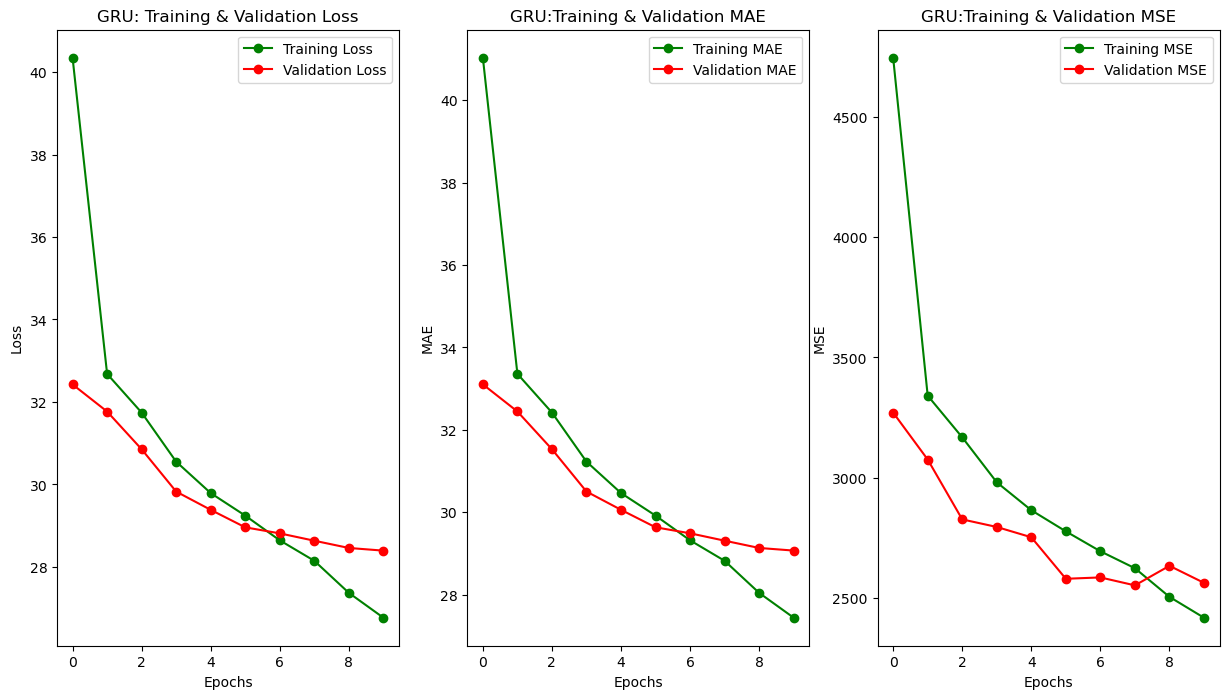

In [24]:
# Learning curve

epochs = [i for i in range(10)]

fig , ax = plt.subplots(1,3)

train_loss = story.history['loss']
train_mae = story.history['mae']
train_mse = story.history['mse']

val_loss = story.history['val_loss']
val_mae = story.history['val_mae']
val_mse = story.history['val_mse']
fig.set_size_inches(15,8)

ax[0].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[0].plot(epochs , val_loss , 'ro-' , label = 'Validation Loss')
ax[0].set_title('GRU: Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(epochs , train_mae , 'go-' , label = 'Training MAE')
ax[1].plot(epochs , val_mae , 'ro-' , label = 'Validation MAE')
ax[1].set_title('GRU:Training & Validation MAE')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("MAE")

ax[2].plot(epochs , train_mse , 'go-' , label = 'Training MSE')
ax[2].plot(epochs , val_mse , 'ro-' , label = 'Validation MSE')
ax[2].set_title('GRU:Training & Validation MSE')
ax[2].legend()
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("MSE")

plt.show()

### 4.2.2 LSTM
For the LSTM model, we add a Dropout layer for combating overfitting.

In [29]:
# LSTM model
input_text = Input(shape=(400, ))
input_feats = Input(shape=(41, ))

input_embed = Embedding(input_dim=vocab_size, output_dim=100, weights=[glove_emb], input_length=400, trainable=False)(input_text)
lstm_text = LSTM(128, return_sequences=False)(input_embed)
lstm_text_dropout = Dropout(0.2)(lstm_text) # dropout regularization added for reducing overfitting
lstm_out = Dense(1, activation='linear')(lstm_text_dropout) 

# Concatenating text and non-text data
concat = concatenate([lstm_out, input_feats])
dense_full = Dense(1024, activation="relu")(concat)
dense_full = Dense(512, activation="relu")(dense_full)
dense_full = Dense(256, activation="relu")(dense_full)
output_layer = Dense(1, activation="linear")(dense_full)

lstm = Model(inputs=[input_text, input_feats], outputs=output_layer)
lstm.compile(loss=losses.LogCosh(), optimizer='adam', metrics=['mae', 'mse'])
print(lstm.summary())

callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=0.01, restore_best_weights=True)]

story = lstm.fit([X_train_text_pad, X_train_ml], y_train, epochs=10, verbose=1, batch_size=256, validation_split=0.2, callbacks=callbacks) 

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 400)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 400, 100)     3866200     ['input_7[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 128)          117248      ['embedding_3[0][0]']            
                                                                                                  
 dropout_1 (Dropout)            (None, 128)          0           ['lstm_1[0][0]']                 
                                                                                            

2023-08-30 16:33:15.415019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-30 16:33:15.416574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-30 16:33:15.417514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

139/139 [==============================] - ETA: 0s - loss: 40.3965 - mae: 41.0793 - mse: 4758.4883

2023-08-30 16:37:24.607892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-30 16:37:24.609204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-30 16:37:24.610323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

139/139 [==============================] - 271s 2s/step - loss: 40.3965 - mae: 41.0793 - mse: 4758.4883 - val_loss: 32.3633 - val_mae: 33.0440 - val_mse: 3271.9507
Epoch 2/10
139/139 [==============================] - 264s 2s/step - loss: 32.6423 - mae: 33.3224 - mse: 3326.8979 - val_loss: 31.9948 - val_mae: 32.6740 - val_mse: 3078.0439
Epoch 3/10
139/139 [==============================] - 267s 2s/step - loss: 32.3973 - mae: 33.0776 - mse: 3277.0403 - val_loss: 31.9201 - val_mae: 32.6005 - val_mse: 2960.0645
Epoch 4/10
139/139 [==============================] - 266s 2s/step - loss: 31.9418 - mae: 32.6210 - mse: 3190.6130 - val_loss: 31.4506 - val_mae: 32.1308 - val_mse: 2913.0522
Epoch 5/10
139/139 [==============================] - 267s 2s/step - loss: 31.2879 - mae: 31.9671 - mse: 3091.4150 - val_loss: 31.8651 - val_mae: 32.5469 - val_mse: 2827.5476
Epoch 6/10
139/139 [==============================] - 268s 2s/step - loss: 30.8639 - mae: 31.5430 - mse: 3032.6494 - val_loss: 30.6422 -

In [30]:
pred_lstm = lstm.predict([X_test_text_pad, X_test_ml])

2023-08-30 17:18:57.148415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-30 17:18:57.149958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-30 17:18:57.150920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

346/346 [==============================] - 38s 109ms/step


In [31]:
print(f"Text MSE: {mean_squared_error(pred_lstm, y_test)}")
print(f"Text MAE: {mean_absolute_error(pred_lstm, y_test)}") 

Text MSE: 2747.4946903143214
Text MAE: 30.506036751522792


The LSTM model performs slightly worse than the GRU model. With the introduction of a dropout layer, overfitting seems to be reduced, but the model's performance displays a certain degree of instability.

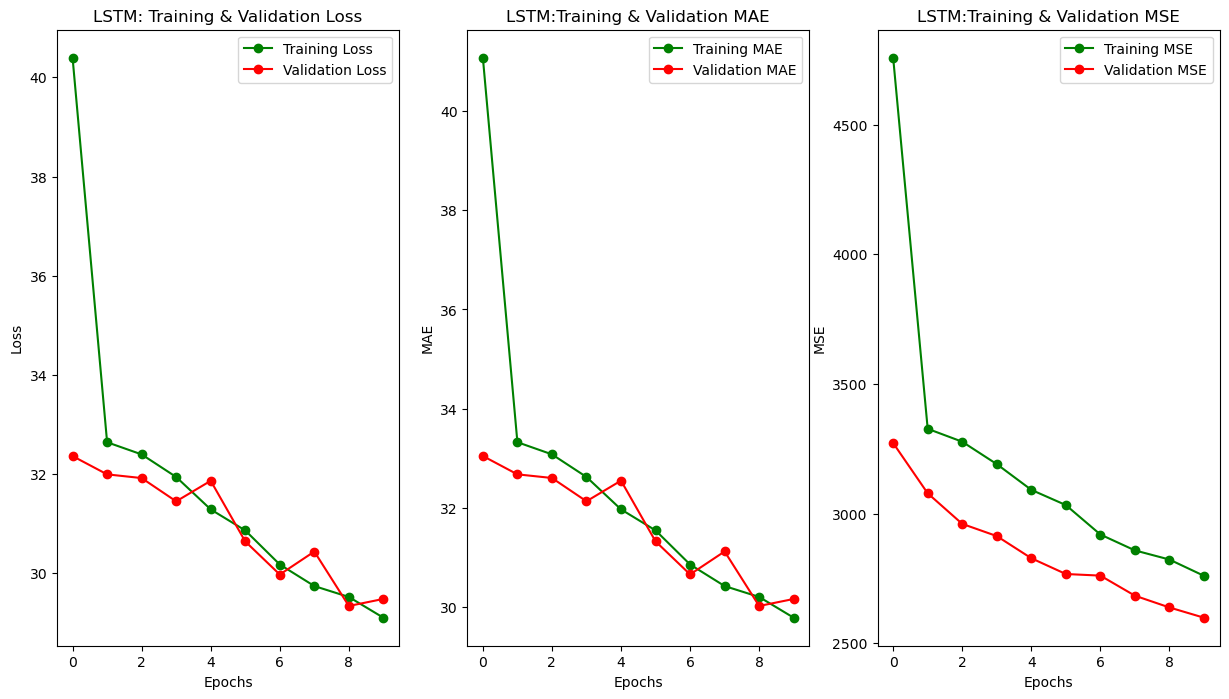

In [32]:
# Learning curve

epochs = [i for i in range(10)]

fig , ax = plt.subplots(1,3)

train_loss = story.history['loss']
train_mae = story.history['mae']
train_mse = story.history['mse']

val_loss = story.history['val_loss']
val_mae = story.history['val_mae']
val_mse = story.history['val_mse']
fig.set_size_inches(15,8)

ax[0].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[0].plot(epochs , val_loss , 'ro-' , label = 'Validation Loss')
ax[0].set_title('LSTM: Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(epochs , train_mae , 'go-' , label = 'Training MAE')
ax[1].plot(epochs , val_mae , 'ro-' , label = 'Validation MAE')
ax[1].set_title('LSTM:Training & Validation MAE')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("MAE")

ax[2].plot(epochs , train_mse , 'go-' , label = 'Training MSE')
ax[2].plot(epochs , val_mse , 'ro-' , label = 'Validation MSE')
ax[2].set_title('LSTM:Training & Validation MSE')
ax[2].legend()
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("MSE")

plt.show()

#### 4.2.3 TextCNN  
Both GRU and LSTM models are types of RNN architecture that is often used for sequence data like text, since they have gating mechanism that allow them to capture long-term dependencies and remember information over longer sequences. For our third experiment, we decide to try out the CNN model.  

Although CNN is typically used for text classification tasks, we expect to leaverage its advantage of detecting local patterns in text data. For example, it may be able to capture certain phrases or combinations of words that tend to appear alongside mentions of price changes.

For our TextCNN model, we introduce 3 convolutional layers with different kernal size for extracting different patterns, each followed by a pooling layer, which uses a max operation to pool sets of features. We also add dropout layers after the flattened concatenated convolutional layers and after each dense layer. The number of neurons in the dense layers have been reduced as well. All these strategies are meant to help mitigate overfitting.   

In [51]:
# TextCNN model

input_text = Input(shape=(400, ))
input_feats = Input(shape=(41, ))

input_embed = Embedding(input_dim=vocab_size, output_dim=100, weights=[glove_emb], input_length=400, trainable=False)(input_text)
cnn1 = Conv1D(filters=64, kernel_size=3, padding='same', strides=1, activation='relu')(input_embed)
cnn1 = MaxPooling1D(pool_size=6)(cnn1)
cnn2 = Conv1D(filters=64, kernel_size=4, padding='same', strides=1, activation='relu')(input_embed)
cnn2 = MaxPooling1D(pool_size=6)(cnn2)
cnn3 = Conv1D(filters=64, kernel_size=5, padding='same', strides=1, activation='relu')(input_embed)
cnn3 = MaxPooling1D(pool_size=6)(cnn3)
cnn = concatenate([cnn1, cnn2, cnn3], axis=-1)
flat = Flatten()(cnn)
drop = Dropout(0.4)(flat) # dropout layer
cnn_out = Dense(1, activation='linear')(drop)

# Concatenating text and non-text data
concat = concatenate([cnn_out, input_feats])
dense_full = Dense(256, activation="relu", kernel_regularizer=l2(0.01))(concat) # regularization introduced; fewer neurons
dense_full = Dropout(0.2)(dense_full) # dropout layer added after each dense layer
dense_full = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(dense_full) 
dense_full = Dropout(0.2)(dense_full) 
dense_full = Dense(64, activation="relu", kernel_regularizer=l2(0.01))(dense_full)
dense_full = Dropout(0.2)(dense_full) 
output_layer = Dense(1, activation="linear")(dense_full)

textcnn = Model(inputs=[input_text, input_feats], outputs=output_layer)
textcnn.compile(loss=losses.LogCosh(), optimizer='adam', metrics=['mae', 'mse'])
print(textcnn.summary())

callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=0.01, restore_best_weights=True)]
story = textcnn.fit([X_train_text_pad, X_train_ml], y_train, epochs=10, verbose=1, batch_size=256, validation_split=0.2, callbacks=callbacks)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 400)]        0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 400, 100)     3866200     ['input_17[0][0]']               
                                                                                                  
 conv1d_11 (Conv1D)             (None, 400, 64)      19264       ['embedding_8[0][0]']            
                                                                                                  
 conv1d_12 (Conv1D)             (None, 400, 64)      25664       ['embedding_8[0][0]']            
                                                                                            

In [52]:
pred_textcnn = textcnn.predict([X_test_text_pad, X_test_ml])

346/346 [==============================] - 12s 33ms/step


In [53]:
print(f"Text MSE: {mean_squared_error(pred_textcnn, y_test)}")
print(f"Text MAE: {mean_absolute_error(pred_textcnn, y_test)}") 

Text MSE: 2912.056237116718
Text MAE: 30.920693877852287


To our surprise, the TextCNN model yields a worse outcome. Notably, despite incorporating various strategies to combat overfitting, it still occured after the 5th epoch, earlier than in the GRU and LSTM model. Different number of layers and neurons were also experimented with, but the improvement in terms of reducing overfitting was either marginal or, in some instances, led to overall poorer model performance.

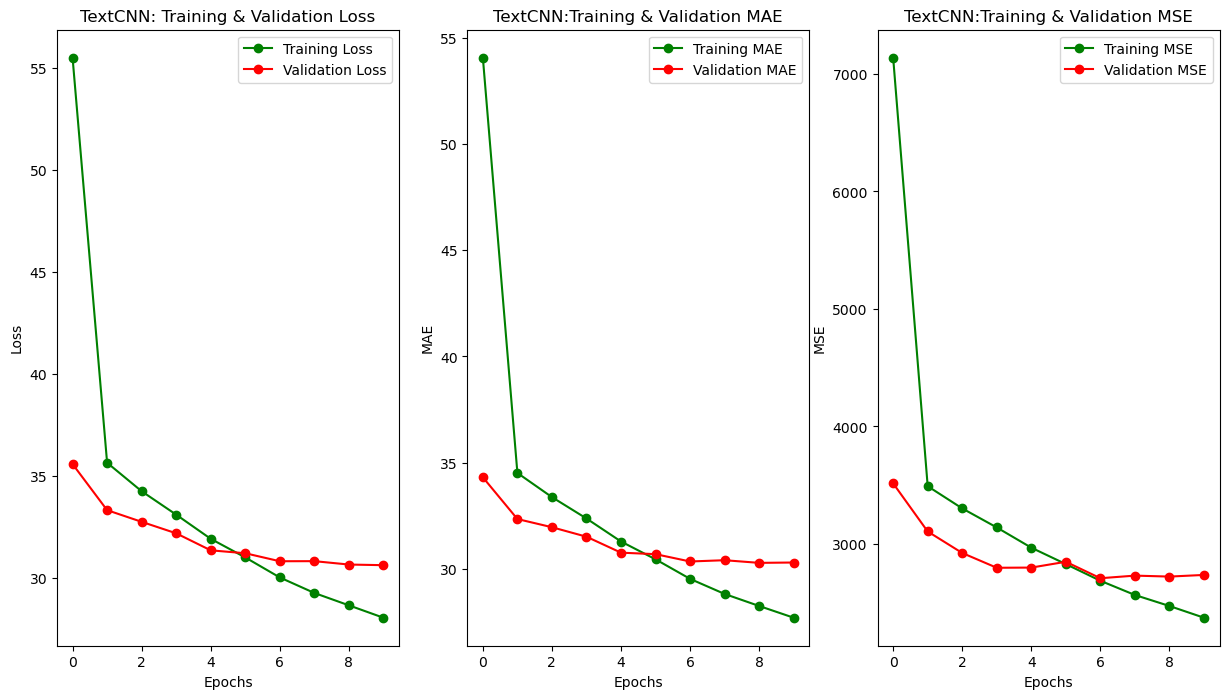

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs = [i for i in range(10)]

fig , ax = plt.subplots(1,3)

train_loss = story.history['loss']
train_mae = story.history['mae']
train_mse = story.history['mse']

val_loss = story.history['val_loss']
val_mae = story.history['val_mae']
val_mse = story.history['val_mse']
fig.set_size_inches(15,8)

ax[0].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[0].plot(epochs , val_loss , 'ro-' , label = 'Validation Loss')
ax[0].set_title('TextCNN: Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(epochs , train_mae , 'go-' , label = 'Training MAE')
ax[1].plot(epochs , val_mae , 'ro-' , label = 'Validation MAE')
ax[1].set_title('TextCNN:Training & Validation MAE')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("MAE")

ax[2].plot(epochs , train_mse , 'go-' , label = 'Training MSE')
ax[2].plot(epochs , val_mse , 'ro-' , label = 'Validation MSE')
ax[2].set_title('TextCNN:Training & Validation MSE')
ax[2].legend()
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("MSE")

plt.show()

### 4.3 Comprehensive Model Architecture

After multiple experiments, we decide to employ a GRU model for our final architecture, as it has shown better performance with relatively shorter training time.   

To retrain the model on the entire training set, we need to prepare our data, including reinitializing the tokenizer and training it on the the entire training text data.

In [6]:
# Preparing the entire training set 

cat_feas = ['neighbourhood_cleansed', 'room_type']
text_feas = ['description_merged_cleaned']
target = ['price']

# Preparing text data
train_text = np.squeeze(train[text_feas].values).tolist()
train_text = [text if text and not pd.isna(text) else "" for text in train_text]

# One-hot encoding categorical features
enc = OneHotEncoder(sparse=False)
train_cat = enc.fit_transform(train[cat_feas])

# Scaling numeric features
to_scale = ['host_total_listings_count', 'reviews_per_month', 'num_of_amenities'] # 'is_real_bed' is a binary feature, and 'accom_room' is the principal component, therefore both are excluded
standard_scaler = StandardScaler()
train_scl = standard_scaler.fit_transform(train[to_scale])

# Extracting values of features that don't need to be standardized
train_not_scl = train[['is_real_bed', 'accom_room']].values

# Bringing all structural data together
train_ml = np.hstack((train_cat, train_scl, train_not_scl))

# Preparing the target variable
y = np.squeeze(train[target].values)


In [7]:
# Checking the shape of structural data
print(train_ml.shape)

(55284, 41)


In [8]:
# Tokenization

maxlen = 400

tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(train_text) 

train_text_seq = tokenizer.texts_to_sequences(train_text)
train_text_pad = pad_sequences(train_text_seq, maxlen)

max_text_len = max([len(text) for text in train_text_seq])
print('The longest text in the entire training set has {} words.'.format(max_text_len))

vocab_size = len(tokenizer.word_index) + 1
print('Found %s unique tokens in the entire training set.' % vocab_size)

print('Shape of training text data:', train_text_pad.shape)

The longest text in the entire training set has 736 words.
Found 42645 unique tokens in the entire training set.
Shape of training text data: (55284, 400)


As we observed overfitting starting from the 6th epoch in the previous experiment with GRU model, we choose to add more Dropout layers and use fewer neurons in our final model.

In [21]:
# GRU final model

input_text = Input(shape=(400, ))
input_feats = Input(shape=(41, ))

input_embed = Embedding(input_dim=vocab_size, output_dim=100, weights=[glove_emb], input_length=400, trainable=False)(input_text)
gru_text = GRU(128, return_sequences=False)(input_embed)
gru_text_dropout = Dropout(0.2)(gru_text) # dropout layer added
gru_out = Dense(1, activation='linear')(gru_text_dropout) 

# Concatenating text and non-text data
concat = concatenate([gru_out, input_feats])
dense_full = Dense(512, activation="relu")(concat) # reduced number of neurons
dense_full = Dropout(0.2)(dense_full) # dropout layer added after each dense layer
dense_full = Dense(256, activation="relu")(dense_full)
dense_full = Dropout(0.2)(dense_full) 
dense_full = Dense(128, activation="relu")(dense_full)
dense_full = Dropout(0.2)(dense_full)
output_layer = Dense(1, activation="linear")(dense_full)

gru = Model(inputs=[input_text, input_feats], outputs=output_layer)
gru.compile(loss=losses.LogCosh(), optimizer='adam', metrics=['mae', 'mse'])
print(gru.summary())

callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=0.01, restore_best_weights=True)]

story = gru.fit([train_text_pad, train_ml], y, epochs=15, verbose=1, batch_size=256, validation_split=0.2, callbacks=callbacks) 

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 400)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 400, 100)     4264500     ['input_3[0][0]']                
                                                                                                  
 gru_1 (GRU)                    (None, 128)          88320       ['embedding_1[0][0]']            
                                                                                                  
 dropout_4 (Dropout)            (None, 128)          0           ['gru_1[0][0]']                  
                                                                                            

2023-09-01 12:36:32.689025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-01 12:36:32.690580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-01 12:36:32.691549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

173/173 [==============================] - ETA: 0s - loss: 42.6008 - mae: 43.2836 - mse: 5166.5015

2023-09-01 12:40:35.603967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-01 12:40:35.605643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-01 12:40:35.606733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

173/173 [==============================] - 264s 2s/step - loss: 42.6008 - mae: 43.2836 - mse: 5166.5015 - val_loss: 32.5693 - val_mae: 33.2506 - val_mse: 3297.3247
Epoch 2/15
173/173 [==============================] - 259s 1s/step - loss: 33.5697 - mae: 34.2499 - mse: 3457.4463 - val_loss: 31.9437 - val_mae: 32.6245 - val_mse: 3119.7070
Epoch 3/15
173/173 [==============================] - 257s 1s/step - loss: 32.6034 - mae: 33.2833 - mse: 3295.5242 - val_loss: 30.8067 - val_mae: 31.4860 - val_mse: 2977.7141
Epoch 4/15
173/173 [==============================] - 256s 1s/step - loss: 31.5096 - mae: 32.1890 - mse: 3099.0876 - val_loss: 29.8100 - val_mae: 30.4902 - val_mse: 2752.8113
Epoch 5/15
173/173 [==============================] - 258s 1s/step - loss: 30.7197 - mae: 31.3986 - mse: 2970.8408 - val_loss: 29.3587 - val_mae: 30.0366 - val_mse: 2789.7947
Epoch 6/15
173/173 [==============================] - 260s 2s/step - loss: 29.9494 - mae: 30.6280 - mse: 2851.8318 - val_loss: 29.2166 -

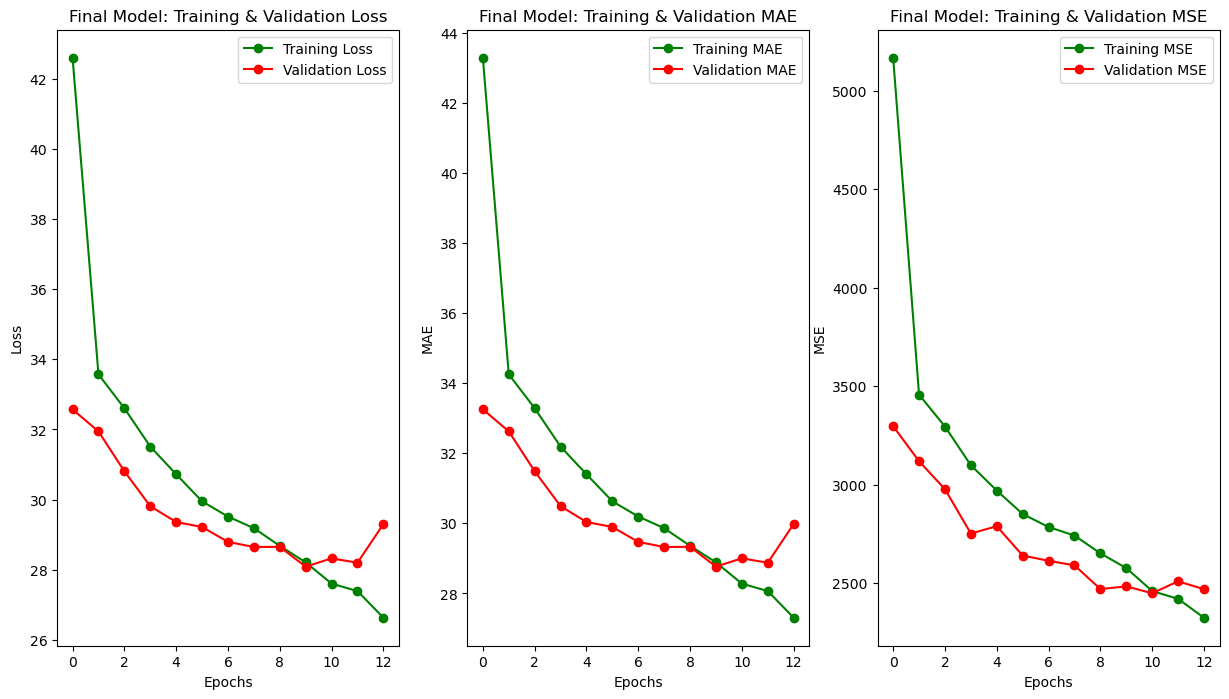

In [23]:
# Learning curve

epochs = [i for i in range(13)]

fig , ax = plt.subplots(1,3)

train_loss = story.history['loss']
train_mae = story.history['mae']
train_mse = story.history['mse']

val_loss = story.history['val_loss']
val_mae = story.history['val_mae']
val_mse = story.history['val_mse']
fig.set_size_inches(15,8)

ax[0].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[0].plot(epochs , val_loss , 'ro-' , label = 'Validation Loss')
ax[0].set_title('Final Model: Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(epochs , train_mae , 'go-' , label = 'Training MAE')
ax[1].plot(epochs , val_mae , 'ro-' , label = 'Validation MAE')
ax[1].set_title('Final Model: Training & Validation MAE')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("MAE")

ax[2].plot(epochs , train_mse , 'go-' , label = 'Training MSE')
ax[2].plot(epochs , val_mse , 'ro-' , label = 'Validation MSE')
ax[2].set_title('Final Model: Training & Validation MSE')
ax[2].legend()
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("MSE")

plt.show()

## 5. Application to Test Set
With the final model trained on the entire training set, we are now ready to apply it to our test set. Before that, the test set needs to be prepared following the same procedures.

In [24]:
test_text = np.squeeze(test[text_feas].values).tolist()
test_text = [text if text and not pd.isna(text) else "" for text in test_text]

test_cat = enc.transform(test[cat_feas])

test_scl = standard_scaler.transform(test[to_scale])

test_not_scl = test[['is_real_bed', 'accom_room']].values

test_ml = np.hstack((test_cat, test_scl, test_not_scl))

In [25]:
# Tokenization of text data in the test set

test_text_seq = tokenizer.texts_to_sequences(test_text)
test_text_pad = pad_sequences(test_text_seq, maxlen)

max_text_len = max([len(text) for text in test_text_seq])
print('The longest text in the test set has {} words.'.format(max_text_len))

vocab_size = len(tokenizer.word_index) + 1
print('Found %s unique tokens in the test set.' % vocab_size)

print('Shape of test text data:', test_text_pad.shape)

The longest text in the test set has 499 words.
Found 42645 unique tokens in the test set.
Shape of test text data: (29769, 400)


The linear activation function in the last layers would output negative values. Since it doesn't align with the context of our task where the target price should never be negative, we limit the predicted values to be in the non-negative range.  

In [26]:
pred_gru_final = gru.predict([test_text_pad, test_ml])
pred_gru_final = np.clip(pred_gru_final, a_min=0, a_max=None)

  1/931 [..............................] - ETA: 5:18

2023-09-01 13:36:28.490872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-01 13:36:28.492439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-01 13:36:28.493440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

931/931 [==============================] - 57s 61ms/step


In [27]:
pred_gru_final = pd.DataFrame(pred_gru_final, columns=["Price"], index=test['listing_id'])
pred_gru_final.to_csv("submission_gru_final.csv")

## 6. Conclusion

Completing this assignment has reinforced our understanding of NLP concepts learned in the lectures by applying the knowledge to solve a real-world problem. We've gained valuable insights into different neural network models, learning their strengths and limitations. This experience has allowed us to develop a comprehensive understanding of the entire pipeline for solving such tasks.  

There is surely room for improvements. Notably, our Neural Network models didn't significantly outperform benchmark models using only structural data. This could be due to the text data preprocessing not being comprehensive enough, or the text data itself containing limited price-related information.  

We recognize that our data preprocessing, particularly for text data, could be more thorough. We believe there are more effective techniques for extracting valuable information from text, and exploring advanced NLP models like transformers could be advantageous if the computational resources allow.  

Additionally, our feature selection and engineering efforts could be enhanced, especially given the large number of features in our dataset. Focusing on the most predictive features and considering feature interactions are key areas for further development. Addressing overfitting while maintaining good model performance remains an ongoing challenge.  
